In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tqdm.notebook import tqdm
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import numpy.random as npr
import os, time, gc, random
import glob
import PIL
from tqdm.auto import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

Layer

In [ ]:
# blocks used in GAN

def minibatchStd(inputs):
    inputs = tf.transpose(inputs, (0, 3, 1, 2)) # NHWC -> NCHW
    group_size = tf.minimum(4, tf.shape(inputs)[0])             # Minibatch must be divisible by (or smaller than) group_size.
    s = inputs.shape                                             # [NCHW]  Input shape.
    y = tf.reshape(inputs, [group_size, -1, 1, s[1], s[2], s[3]])   # [GMncHW] Split minibatch into M groups of size G. Split channels into n channel groups c.
    y -= tf.reduce_mean(y, axis=0, keepdims=True)           # [GMncHW] Subtract mean over group.
    y = tf.reduce_mean(tf.square(y), axis=0)                # [MncHW]  Calc variance over group.
    y = tf.sqrt(y + eps)                                    # [MncHW]  Calc stddev over group.
    y = tf.reduce_mean(y, axis=[2,3,4], keepdims=True)      # [Mn111]  Take average over fmaps and pixels.
    y = tf.reduce_mean(y, axis=[2])                         # [Mn11] Split channels into c channel groups
    y = tf.tile(y, [group_size, 1, s[2], s[3]])             # [NnHW]  Replicate over group and pixels.
    y = tf.concat([inputs, y], axis=1)                        # [NCHW]  Append as new fmap.
    y = tf.transpose(y, (0, 2, 3, 1)) # NCHW -> NHWC
    return y

class DiffUS(tf.keras.layers.Layer):
    def __init__(self):
        return super().__init__()
    
    def call(self, inputs):
        _N, H, W, C = inputs.shape.as_list()
        x = K.reshape(inputs, (-1, H, 1, W, 1, C))
        x = tf.tile(x, (1, 1, 2, 1, 2, 1))
        used = K.reshape(x, (-1, H * 2, W * 2, C))
        return used

def crop_to_fit(x):
    noise, img = x
    height = img.shape[1]
    width = img.shape[2]
    
    return noise[:, :height, :width, :]

ndist = tf.random_normal_initializer(0, 1)
zeros = tf.zeros_initializer()
ones = tf.ones_initializer()

class FCE(Dense): # fully connected equalized
    def __init__(self, units, kernel_initializer=ndist, bias_initializer=zeros, lrelu=True, *args, **kwargs):
        super().__init__(units, *args, **kwargs)
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.lrelu = lrelu
        self.scale = 1

    def build(self, input_shape):
        super().build(input_shape)
        #print('fce', input_shape)
        n = input_shape[-1] # input_shape = (None, features_in) or (None, dimY, dimX, features_in)
        if self.lrelu:
            self.scale = np.sqrt((1 / 0.6) / n) # he but not really, 1 / 0.6 since lrelu(0.2) makes scales variance to 0.6 (0.2 if neg, 1 if pos, div by 2) and you want them to be 1
        else:
            self.scale = np.sqrt(1 / n)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel * self.scale)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not tf.keras.activations.linear:
            output = self.activation(output)
        elif self.lrelu:
            output = LeakyReLU(alpha=0.2)(output)
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'kInit': self.kernel_initializer,
            'bInit': self.bias_initializer,
            'scale': self.scale,
            'useLReLU': self.lrelu,
                      })
        return config

class CVE(Conv2D):
    def __init__(self, units, kernel_size=3, kernel_initializer=ndist, bias_initializer=zeros, padding='same', lrelu=True, *args, **kwargs):
        super().__init__(units, kernel_size, *args, **kwargs)
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.padding = padding
        self.lrelu = lrelu
        self.scale = 1

    def build(self, input_shape):
        super().build(input_shape)
        #print('cve', self.kernel.shape)
        n = np.prod(self.kernel.shape[:-1]) # self.kernel.shape = (kernel_x, kernel_y, features_in, features_out)
        if self.lrelu: # he
            self.scale = np.sqrt((1 / 0.6) / n)
        else:
            self.scale = np.sqrt(1 / n)


    def call(self, inputs):
        output = K.conv2d(inputs, self.kernel * self.scale, padding=self.padding)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not tf.keras.activations.linear:
            output = self.activation(output)
        elif self.lrelu:
            output = LeakyReLU(alpha=0.2)(output)
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'kInit': self.kernel_initializer,
            'bInit': self.bias_initializer,
            'padding': self.padding,
            'scale': self.scale,
            'useLReLU': self.lrelu,
                      })
        return config

class ConvMod(Layer):
    def __init__(self, nf, x, w, kSize=3, demod=True):
        super().__init__()
        self.nf = nf
        self.kSize = kSize
        self.xShape = x.shape
        self.wShape = w.shape
        self.scale = FCE(self.xShape[-1], bias_initializer=ones, lrelu=False)
        self.conv = CVE(nf, kSize, lrelu=demod)
        self.conv(x) # create kernel without doing it in build method so h5py doesn't go sicko mode
        self.demod = demod

    def build(self, input_shape): # input_shape: [TensorShape([None, 4, 4, 256]), TensorShape([None, 256]), TensorShape([None, 4, 4, 1])]
        super().build(input_shape)

    def call(self, inputs):
        x, w = inputs

        x = tf.transpose(x, (0, 3, 1, 2)) # NHWC -> NCHW
        weight = self.conv.kernel[np.newaxis] * self.conv.scale # kkio -> 1kkio (1, kernel_size, kernel_size, input_features, output_features)

        scale = self.scale(w)
        scale = scale[:, np.newaxis, np.newaxis, :, np.newaxis] # Bs -> B, 1, 1, s, 1 (s - scaling factor)

        wp = weight * scale # 1kkio * B11s1 -> Bkk(s*i)o
        wpp = wp

        if self.demod:
            wStd = tf.math.rsqrt(tf.reduce_sum(tf.math.square(wp), axis=[1,2,3]) + 1e-8) # Bkkio -> Bo
            wpp = wp * wStd[:, np.newaxis, np.newaxis, np.newaxis, :] # [BkkIO] Scale output feature maps.

        x = tf.reshape(x, (1, -1, x.shape[2], x.shape[3])) # N, C, H, W -> 1, (N*C), H, W

        # B, k, k, i, o -> k, k, i, B, o -> k, k, i, (B*o)
        wpp = tf.reshape(tf.transpose(wpp, [1, 2, 3, 0, 4]), [wpp.shape[1], wpp.shape[2], wpp.shape[3], -1])

        x = tf.nn.conv2d(x, wpp, padding='SAME', data_format='NCHW', strides=[1, 1, 1, 1]) # grouped conv
        x = tf.reshape(x, (-1, self.nf, x.shape[2], x.shape[3])) # 1, (N*C), H, W -> N, C, H, W
        x = tf.transpose(x, (0, 2, 3, 1)) # NCHW -> NHWC
        x = K.bias_add(x, self.conv.bias)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_filters': self.nf,
            'kernel_size': self.kSize,
            'xShape': self.xShape,
            'wShape': self.wShape,
            'demodulated': self.demod
                      })
        return config

TimeIt

In [ ]:
# custom class to see how long tasks take
class timeIt:
    def __init__(self, description):
        self.start = time.time()
        self.description = description
        self.running = True
    
    def new(self, description, verbose=True):
        self.start = time.time()
        self.description = description
        
        duration = time.time() - startTime
        if verbose:
            print('{}; {:.4f} seconds to complete'.format(self.description, duration))
        
        return duration
    
    def close(self, verbose=True):
        duration = time.time() - self.start
        if verbose:
            print('{}; {:.4f} seconds to complete'.format(self.description, duration))
            
        self.start = None
        self.description = None
        self.running = False
        return duration

sess = timeIt('testing timer')
time.sleep(0.005)
_ = sess.close(verbose=True)

Hyperparameters

In [ ]:
# reals - numpy array of the training images; ds - batched TF dataset given to the GPU
datasetPath = '../../data/patch_1024_png/*.png'
modelPath = '../../model/styleGAN2/1024/'
reals, ds = None, None
gc.collect()

batchSize = 4
m = 2000 # amount of images stored in RAM (reduce if low RAM, increase if high RAM)
m = min(m, int(len(glob.glob(datasetPath))))

m = batchSize * (m // batchSize)
imgSize =512# size of images in pixels
zdim = imgSize # number of elements in a latent vector
p = 0.0 # probability of data augmentation
n = 4 # number of minibatches before p is changed
numImgsStep = 5e5 # number of images needed to change p from 0 -> 1 or 1 -> 0
pStep = n * batchSize / numImgsStep # how much p increases/decreases per n minibatches
eps = 1e-8 # epsilon, small number used to prevent NaN errors
pplEMA = 0.0 # exponential moving average for average PPL for PPL reg.
discLayerFilters = np.linspace(32,imgSize,int(np.log2(imgSize/4)),dtype=np.int32)
genLayerFilters = np.linspace(imgSize,32,int(np.log2(imgSize/4)),dtype=np.int32)
w1_range=int(np.log2(imgSize/2)/2)
w2_range=int(np.log2(imgSize/2)/2+(np.log2(imgSize/2)%2>=0.5))

Load data

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE


'''
goes into datasetPath, chooses and stores image data from random files (repeats allowed)
into a np array, converts the array into the TF dataset

Args:
others - random indices for files to choose to train the GAN on
verbose - determines whether duration to complete is printed out or not
'''
def loadData(others=None, verbose=True):
    global reals, ds, m
    sess = timeIt('Loading data')
    reals, ds = None, None
    gc.collect()
    files = glob.glob(datasetPath)
    
    reals = np.zeros((len(files), imgSize, imgSize, 3))
    for i in tqdm(range(len(files))):
        strI = str(files[i])
        img1=PIL.Image.open(strI).convert("RGB")
        if(img1.size[0]>=img1.size[1]):
            ratio=imgSize/img1.size[0]
        else:
            ratio=imgSize/img1.size[1]
        width=ratio*img1.size[0]
        height=ratio*img1.size[1]
        height_padding_size=int((imgSize-height)/2)
        width_padding_size=int((imgSize-width)/2)
        img1=np.array(img1.resize((int(width),int(height))))
        reals[i] = img1
        del img1
    
    reals = reals[:m].astype(np.float32)/127.5-1.0

    assert reals.shape[0] % batchSize == 0
    assert type(reals) == np.ndarray
    ds = (tf.data.Dataset.from_tensor_slices(reals).shuffle(3000).batch(batchSize))
    ds = ds.prefetch(AUTO)
    gc.collect()
    sess.close(verbose=verbose)
    
def aug(imgs, p):
    augImgs = imgs
    def augCond(x):
        randInds = tf.random.uniform((batchSize,))
        trueCond = tf.cast(randInds < p, tf.float32) # using tf.cast to turn booleans into ones and zeros
        falseCond = tf.cast(randInds >= p, tf.float32)
        auged = x * tf.reshape(trueCond, (batchSize, 1, 1, 1)) + augImgs * tf.reshape(falseCond, (batchSize, 1, 1, 1))
        return auged
    
    height = tf.random.uniform((), minval=0.5, maxval=1)
    width = tf.random.uniform((), minval=0.5, maxval=1)
    boxLite = tf.random.uniform((batchSize, 2), maxval=(1-height, 1-width))
    boxes = tf.concat([boxLite, tf.transpose(boxLite[:, 0][np.newaxis]) + height, tf.transpose(boxLite[:, 1][np.newaxis]) + width], axis=1)
    boxLiteIso = tf.random.uniform((batchSize, 1), maxval=1-height)
    boxIso = tf.concat([boxLite, tf.transpose(boxLiteIso[:, 0][np.newaxis]) + height, tf.transpose(boxLiteIso[:, 0][np.newaxis]) + height], axis=1)
    rot90s = np.pi * 90 * tf.cast(tf.random.uniform((batchSize,), minval=0, maxval=4, dtype=tf.int32), tf.float32) / 180
    augImgs = augCond(tf.image.random_brightness(augImgs, max_delta=0.25))
    augImgs = augCond(tf.image.crop_and_resize(augImgs, boxIso, tf.range(batchSize), (imgSize, imgSize), extrapolation_value=1))
    augImgs = augCond(tf.image.crop_and_resize(augImgs, boxes, tf.range(batchSize), (imgSize, imgSize), extrapolation_value=1))
    augImgs = augCond(tfa.image.rotate(augImgs, rot90s))
    augImgs = augCond(tfa.image.rotate(augImgs, tf.random.uniform((batchSize,), minval=-np.pi/6, maxval=np.pi/6)))
    augImgs = augCond(tfa.image.translate(augImgs, tf.random.normal((batchSize, 2), 0, imgSize // 10)))
    return augImgs
loadData()

Layers

In [ ]:
'''
Generator style block.
Args:
accum - accumulated output from the input/output skips
x - the non-RGB image input
w - the style (output of the mapping function with input of the latent vector)
noiseInp - normally distributed noise
filters - number of channels/feature maps the output of the style block will have
us - whether or not to upsample the images
'''
def gblock(accum, x, w, noiseInp, filters, us=True):
    if us:
        x = DiffUS()(x) # using custom upsampling function since other upsampling methods didn't provide gradients of their gradients
        accum = DiffUS()(accum)
    
    for i in range(2):
        x = ConvMod(filters, x, w)([x, w])
        noise = Lambda(crop_to_fit)([noiseInp, x]) # crop noises so it can be added with x
        noise = FCE(filters, kernel_initializer=zeros, use_bias=False, lrelu=False)(noise) #scale noises
        x = Add()([x, noise])
        x = LeakyReLU(alpha=0.2)(x)
    
    trgb = ConvMod(3, x, w, 1, demod=False)([x, w]) # toRGB 1x1 convolution
    accum = Add()([accum, trgb]) * np.sqrt(1 / 2) # the sqrt(1/2) not included in original StyleGAN2 but i didn't see why not
        
    return accum, x

# Discriminator block.
def dblock(x, filters, maxFilters=256):
    frgb = CVE(min(2 * filters, maxFilters), 1, lrelu=False, use_bias=False)(x)
    
    x = CVE(filters)(x)
    x = CVE(min(2 * filters, maxFilters))(x)
        
    frgb = AveragePooling2D()(frgb)
    x = AveragePooling2D()(x)
    x = Add()([x, frgb])
    
    return x

Build models

In [ ]:
nBlocks = int(np.log2(imgSize / 4)) # number of upsampled style blocks

# mapper architecture
def ztow(nlayers=8):
    z = Input((zdim,))
    w = z
    if nlayers > 0:
        w = LayerNormalization()(w)
    for i in range(max(nlayers-1, 0)):
        w = FCE(zdim)(w)
    return Model(z, w, name='mapping')

# generator architecture
def genGen():
    ws = [Input((zdim,), name='w{}'.format(i)) for i in range(nBlocks+1)]
    noiseInp = Input((imgSize, imgSize, 1), name='noiseInp')

    x = Dense(1)(ws[0]); x = Lambda(lambda x: x * 0 + 1)(x)
    x = FCE(4*4*zdim, lrelu=False, use_bias=False)(x)
    x = Reshape((4, 4, zdim))(x)
    
    
    
    x = ConvMod(genLayerFilters[0], x, ws[0])([x, ws[0]])
    noise = Lambda(crop_to_fit)([noiseInp, x])
    noise = FCE(genLayerFilters[0], kernel_initializer=zeros, use_bias=False, lrelu=False)(noise)
    x = Add()([x, noise])
    x = LeakyReLU(alpha=0.2)(x)
    accum = ConvMod(3, x, ws[0], 1, demod=False)([x, ws[0]])
    
    for idx, f in enumerate(genLayerFilters):
        accum, x = gblock(accum, x, ws[idx+1], noiseInp, f)
        
    out = CVE(3, 1, lrelu=False)(accum)
    return Model([*ws, noiseInp], out, name='generator')
      
# discriminator architecture  
def genDisc():
    inp = Input((imgSize, imgSize, 3)); x = inp

    
    x = CVE(discLayerFilters[0], 1)(x)
    for fi, f in enumerate(discLayerFilters):
        x = dblock(x, f, maxFilters=discLayerFilters[-1])
    
    x = Lambda(minibatchStd)(x)
    x = CVE(discLayerFilters[-1])(x)
    x = Flatten()(x)
    x = FCE(discLayerFilters[-1])(x)
    out = FCE(1, lrelu=False)(x)

    return Model(inp, out, name='discriminator')

In [ ]:
fids, gcosts, dcosts = [], [], []
pplNorms = []
gpcosts = []
ps, rts = [], []


mapper = ztow()
generator = genGen()
discriminator = genDisc()
inception = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(imgSize, imgSize, 3)) # for FID score

Optimizers and losses

In [ ]:
lr = 2e-3 * batchSize / 32
mapOpt = Adam(lr / 100, epsilon=1e-8)
genOpt = Adam(lr, 0, 0.9, epsilon=1e-8)
discOpt = Adam(lr, 0, 0.9, epsilon=1e-8)

In [ ]:
def rt(truePreds): # overfitting metric
    return tf.reduce_mean(tf.sign(truePreds))

def dra(obsPreds, basePreds): # observe/baseline predictions (representing fake/true data)
    meanBase = K.mean(basePreds)
    return tf.nn.sigmoid(obsPreds - meanBase)

def discLoss(truePreds, fakePreds, epsilon=eps):
    trueLoss = K.mean(tf.nn.softplus(-truePreds)) # -log(sigmoid(real_scores_out))
    fakeLoss = K.mean(tf.nn.softplus(fakePreds)) # -log(1-sigmoid(fake_scores_out))
    classLoss = trueLoss + fakeLoss
    return classLoss

def genLoss(fakePreds, epsilon=eps):
    classLoss = K.mean(tf.nn.softplus(-fakePreds))
    return classLoss

Regularizers

In [ ]:
# path length reg.
@tf.function
def pplReg(a=0.0):
    pplbatchSize = batchSize // 2
    y = tf.random.normal((pplbatchSize, imgSize, imgSize, 3))
    noise = tf.random.uniform((pplbatchSize, imgSize, imgSize, 1))
    z = tf.random.normal((pplbatchSize, zdim))
    
    w = mapper(z, training=True)
    ws = [w for _ in range(nBlocks+1)]
    preds = generator([*ws, noise], training=True)
    jacLite = tf.math.reduce_sum(preds * y)
    
    jac = tf.gradients(jacLite, w)[0]
    norm = tf.norm(jac)
    return K.mean(tf.square(norm - tf.cast(a, tf.float32))), norm

FID function

In [ ]:
from scipy.linalg import sqrtm

allRealFeatures = None

# turn TF tensor outputs into numpy array outputs
def toNp(*args):
    ret = []
    for i in args:
        meanVal = i
        try:
            meanVal = i.numpy()
        except:
            pass
        ret.append(meanVal)
    return ret

def calculate_fid():
    global allRealFeatures
    
    def crunch(batch, bs=64):
        z1, z2 = npr.randn(2, bs, zdim)
        noise = npr.randn(bs, imgSize, imgSize, 1)
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(w1_range)] + [w2 for _ in range(w2_range)]
        fakes = generator([*ws, noise], training=False)
        fakeFeatures = inception(fakes/2+0.5, training=False)
        realFeatures = inception(batch/2+0.5, training=False)
        return fakeFeatures.numpy(), realFeatures.numpy()
    def crunchLite(batch, bs=64):
        z1, z2 = npr.randn(2, bs, zdim)
        noise = npr.randn(bs, imgSize, imgSize, 1)
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(w1_range)] + [w2 for _ in range(w1_range)]
        fakes = generator([*ws, noise], training=False)
        fakeFeatures = inception(fakes/2+0.5, training=False)
        return fakeFeatures.numpy(), -1
    
    K.clear_session()
    bs = 16
    expandM = bs * (m//bs)
    crunchFunc = crunchLite
    if allRealFeatures is None:
        crunchFunc = crunch
        allRealFeatures = np.zeros((expandM, 2048))
        
    allFakeFeatures = np.zeros((expandM, 2048))
    for batchS in tqdm(range(0, expandM, bs)):
        batch = reals[batchS: batchS + bs]
        fakeFeatures, realFeatures = crunchFunc(batch, bs=bs)
        allFakeFeatures[batchS: batchS + bs] = fakeFeatures
        
        if crunchFunc == crunch:
            allRealFeatures[batchS: batchS + bs] = realFeatures
        
    # calculate mean and covariance statistics
    fakeMean, fakeStd = np.mean(allFakeFeatures, axis=0), np.cov(allFakeFeatures, rowvar=False)
    realMean, realStd = np.mean(allRealFeatures, axis=0), np.cov(allRealFeatures, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((fakeMean - realMean) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(np.dot(fakeStd, realStd))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(fakeStd + realStd - 2.0 * covmean)
    K.clear_session()
    return fid

Step function

In [ ]:
'''
One training step for the GAN.
Args:
batch - input batch of real images
p - probability of augmenting image
pplEMA - skip PPL reg. if it is -1, else use the value for regularization
useGP - skip R1 gradient penalty if it is -1
'''
@tf.function
def trainStep(batch, p, pplEMA=-tf.ones(()), useGP=-tf.ones(())):
    def genImgs():
        z1 = tf.random.normal([batchSize, zdim])
        z2 = tf.random.normal([batchSize, zdim])
        noise = tf.random.normal([batchSize, imgSize, imgSize, 1])

        w1 = z1; w2 = z2
        w1 = mapper(z1, training=True)
        w2 = tf.cond(tf.random.uniform(()) < 0.9, lambda: mapper(z2, training=True), lambda: w1)
        splitInd = npr.randint(nBlocks+1)
        ws = [w1 for _ in range(splitInd)] + [w2 for _ in range(nBlocks+1-splitInd)]
        fakes = generator([*ws, noise], training=True)
        return fakes
    
    fakes = genImgs()
    augBatch = aug(batch, p)
    augFakes = aug(fakes, p)
    truePreds = discriminator(augBatch, training=True)
    fakePreds = discriminator(augFakes, training=True)

    gpWeight = 16 * 10 / 2
    gploss = tf.cond(useGP >= 0, lambda: gpWeight * K.mean((tf.reduce_sum(tf.square(tf.gradients(truePreds, [augBatch])[0]), axis=[1,2,3]))), lambda: 0.0)

    dloss = discLoss(truePreds, fakePreds) + gploss
    rtBatch = rt(truePreds)
    
    fakes = genImgs()
    augFakes = aug(fakes, p)
    fakePreds = discriminator(augFakes, training=True)

    pplWeight = 8 * 2 / (imgSize * imgSize * (nBlocks + 1))
    pplLoss, pplNorm = tf.cond(pplEMA >= 0, lambda: pplReg(pplEMA), lambda: (0.0, 0.0))
    pplLoss = pplWeight * pplLoss
    gloss = genLoss(fakePreds) + pplLoss
    
    dGrad = tf.gradients(dloss, discriminator.trainable_variables)
    discOpt.apply_gradients(zip(dGrad, discriminator.trainable_variables))

    gGrad = tf.gradients(gloss, generator.trainable_variables)
    genOpt.apply_gradients(zip(gGrad, generator.trainable_variables))
    
    mGrad = tf.gradients(gloss, mapper.trainable_variables)
    mapOpt.apply_gradients(zip(mGrad, mapper.trainable_variables))
    
    return dloss, gploss, gloss, rtBatch, pplLoss, pplNorm

Gradient visualization function

In [ ]:
def retGrads():
    z1 = tf.random.normal([1, zdim])
    z2 = tf.random.normal([1, zdim])
    noise = tf.random.normal([1, imgSize, imgSize, 1])
    randImg = tf.convert_to_tensor(reals[npr.randint(0, reals.shape[0])][np.newaxis])

    with tf.GradientTape() as tapeReal, tf.GradientTape() as tapeFake:
        w1 = z1; w2 = z2
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(3)] + [w2 for _ in range(4)]
        tapeReal.watch(randImg)
        fakes = generator([*ws, noise], training=False)
        tapeFake.watch(fakes)
        truePreds = discriminator(randImg, training=False)
        fakePreds = discriminator(fakes, training=False)
        dloss = discLoss(truePreds, fakePreds)

    realGrad = tapeReal.gradient(dloss, randImg)[0]
    fakeGrad = tapeFake.gradient(dloss, fakes)[0]
    realNorm = tf.norm(realGrad)
    fakeNorm = tf.norm(fakeGrad)
    return realGrad.numpy(), fakeGrad.numpy(), realNorm.numpy(), fakeNorm.numpy(), randImg[0].numpy(), fakes[0].numpy(), truePreds.numpy(), fakePreds.numpy()

Train functions

In [ ]:
def train(epochs=None, steps=None, n=4):
    global p, pplNorms, pplEMA
    gc.collect()
    rtBatches = 0
    
    if epochs != None:
        for i in range(epochs):
            gc.collect()
            dcost, gpcost, gcost = 0, 0, 0
            pplSum = 0
            rtSum, pplCost = 0, 0
            batchNum = 0
            for batch in ds:
                pTensor = tf.convert_to_tensor(p, dtype=tf.float32)
                batch = reals[npr.randint(0, m, (batchSize,))]
                if batchNum % 16 == 0:
                    vals = toNp(*trainStep(batch, pTensor, tf.convert_to_tensor(pplEMA), useGP=tf.ones(())))
                elif batchNum % 8 == 0:
                    vals = toNp(*trainStep(batch, pTensor, tf.convert_to_tensor(pplEMA)))
                else:
                    vals = toNp(*trainStep(batch, pTensor))
                dloss, gploss, gloss, rtBatch, pplLoss, pplNorm = vals

                if pplNorm != 0:
                    pplEMA = 0.01 * pplNorm + 0.99 * pplEMA
                
                rtBatches += rtBatch
                if batchNum % n == 0:
                    p += pStep * np.sign(rtBatches/n - 0.6)
                    p = round(min(max(p, 0), 1), 6) % 0.8
                    rtBatches = 0
                batchNum += 1
                dcost += dloss; gpcost += gploss; gcost += gloss; rtSum += rtBatch; pplCost += pplLoss; pplSum += pplNorm
            
            dcosts.append(dcost)
            gcosts.append(gcost)
            gpcosts.append(gpcost)
            pplNorms.append(round(pplSum / batchNum, 4))
            ps.append(p)
            rts.append(rtBatch)
            print('Epoch: {} | D Cost: {} | GP Cost: {} | G Cost: {}'.format(i, dcost, gpcost, gcost), end = ' | ')
            print('P(aug): {} | Rt: {} | PPL Norm: {} | PPL Loss: {}'.format(p, round(rtSum / batchNum, 4), round(pplSum / batchNum, 4), round(pplCost, 4)))

Display function

In [ ]:
rows, cols = 1, 4

'''
Display generated images as well as a summary of model metrics.
Args:
z1/z2 - latent input vector 1/2
noise - noise input
verbose - 5-element list saying which metrics to calculate and print out
verbose[0] - FID score
verbose[1] - D(G(z)) - discriminator predictions on generated images
verbose[2] - D(x) - discriminator predictions on real images
verbose[3/4] - D/G Loss
verbose=True/1: print everything
verbose=False/0: print nothing
'''

def display(z1, z2, noise, verbose=True):
    gc.collect()
    fig = plt.figure(figsize=(30, 5))
    axes = fig.subplots(rows, cols)
    
    z1[0] = constZ; z2[0] = constZ; noise[0] = constNoise
    assert z1.shape == (rows * cols, zdim)
    assert z2.shape == (rows * cols, zdim)
    assert noise.shape == (rows * cols, imgSize, imgSize, 1)
        
    randInds = npr.randint(0, reals.shape[0], (rows*cols,))
    
    w1 = z1; w2 = z2
    w1 = mapper(z1, training=False)
    w2 = mapper(z2, training=False)
    ws = [w1 for _ in range(w1_range)] + [w2 for _ in range(w2_range)]
    preds = generator([*ws, noise], training=False)
    df = discriminator(preds, training=False)
    dr = discriminator(reals[randInds], training=False)
    if type(verbose) == type(True):
        verbose = [verbose for i in range(5)]
    if type(verbose) == int:
        if verbose == 0:
            verbose = [False for i in range(5)]
        elif verbose == 1:
            verbose = [False, False, False, True, True]
        elif verbose == 2:
            verbose = [False, True, True, True, True]
        elif verbose == 3:
            verbose = [True for i in range(5)]
            
    if verbose[1]:
        print('D(G(z)) (lower = better disc):', np.mean(df))
    if verbose[2]:
        print('D(x) (higher = better disc):', np.mean(dr))
    if verbose[3]:
        print('D Loss:', discLoss(dr, df))
    if verbose[4]:
        print('G Loss:', genLoss(df))
    
    for i in range(rows):
        for j in range(cols):
            axes[j].imshow(preds[i*cols + j] / 2 + 0.5)

    plt.show()
    
    if verbose[0]:
        fid = round(calculate_fid(), 4)
        print('FID:', fid)
        fids.append(fid)
    return preds

Save model function

In [ ]:
'''
Save current state of model, overwriting past state of model on disk.
Args:
askInp - require user to place input before saving models - protects user from accidentally overwriting models with a collapsed model
'''
def save_models(askInp=True):
    if askInp:
        input()
    
    
    generator.save_weights(modelPath+'genWeights.h5')
    discriminator.save_weights(modelPath+'discWeights.h5')
    mapper.save_weights(modelPath+'mapWeights.h5')

Train GAN

In [18]:
constZ = npr.randn(zdim,)
constNoise = npr.randn(imgSize, imgSize, 1)
epoch = 0
if type(reals) != np.ndarray or type(ds) == type(None):
        loadData()
while True:
    sess = timeIt('Training')
    display(z1=npr.randn(rows * cols, zdim), z2=npr.randn(rows * cols, zdim), noise=npr.randn(rows * cols, imgSize, imgSize, 1), verbose=True)
    train(epochs=50)
    epoch += 1
    sess.close()
    save_models(askInp=False)
    np.save(os.path.join(modelPath, 'p.npy'), p) # save p value for future training if training on servers with time limits like Paperspace

Epoch: 7 | D Cost: 480.6519883573055 | GP Cost: 42.2769672870636 | G Cost: 743.9228921830654 | P(aug): 0.3384 | Rt: 0.558 | PPL Norm: 118.9927 | PPL Loss: 25.5697
Epoch: 8 | D Cost: 478.4393565505743 | GP Cost: 44.15841615200043 | G Cost: 710.3397090435028 | P(aug): 0.338304 | Rt: 0.554 | PPL Norm: 115.2426 | PPL Loss: 10.9038
Epoch: 9 | D Cost: 475.8696262538433 | GP Cost: 43.19626933336258 | G Cost: 727.0460097789764 | P(aug): 0.338336 | Rt: 0.543 | PPL Norm: 113.3295 | PPL Loss: 9.304
Epoch: 10 | D Cost: 476.885156840086 | GP Cost: 43.573155879974365 | G Cost: 716.8840757608414 | P(aug): 0.33856 | Rt: 0.535 | PPL Norm: 115.1481 | PPL Loss: 17.1207
Epoch: 11 | D Cost: 466.2244232445955 | GP Cost: 44.27523022890091 | G Cost: 747.4157558381557 | P(aug): 0.338848 | Rt: 0.576 | PPL Norm: 117.8128 | PPL Loss: 12.8568
Epoch: 12 | D Cost: 476.762146666646 | GP Cost: 46.9689747095108 | G Cost: 750.8285920917988 | P(aug): 0.339008 | Rt: 0.568 | PPL Norm: 108.3476 | PPL Loss: 13.487
Epoch: 13 

Visualize gradients

In [19]:
if type(reals) != np.ndarray or type(ds) == type(None):
    #loadData()
    reals = np.load(os.path.join(datasetPath, 'imgs.npy'))
    m = batchSize * (reals.shape[0] // batchSize)
    reals = reals[:m].astype(np.float32)

    assert reals.shape[0] % batchSize == 0
    assert type(reals) == np.ndarray
    ds = (tf.data.Dataset.from_tensor_slices(tf.cast(reals, tf.float32)).shuffle(3000).batch(batchSize))
    ds = ds.prefetch(AUTO)
    gc.collect()

dGrad, gGrad, dNorm, gNorm, img, fake, truePreds, fakePreds = retGrads()
dGrad = np.sum(dGrad, axis=2)
gGrad = np.sum(gGrad, axis=2)
print('D(x): {} | D(G(z)): {}'.format(truePreds, fakePreds))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
dGrad = (dGrad - np.min(dGrad)) / (np.max(dGrad) - np.min(dGrad) + eps)
gGrad = (gGrad - np.min(gGrad)) / (np.max(gGrad) - np.min(gGrad) + eps)
axes[0][0].imshow(img/2+0.5)
axes[0][1].imshow(fake/2+0.5)
axes[1][0].imshow(dGrad)
axes[1][0].set_title('Real Grad; Norm: {}'.format(round(dNorm, 4)))
axes[1][1].imshow(gGrad)
axes[1][1].set_title('Fake Grad; Norm: {}'.format(round(gNorm, 4)))
plt.show()

ValueError: Layer "generator" expects 9 input(s), but it received 8 input tensors. Inputs received: [<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 5.13829768e-01, -1.02527462e-01,  1.66984484e-01,
        -3.15205336e-01,  4.67206985e-01,  1.62866771e-01,
        -3.84761170e-02, -1.26496106e-01, -2.08367422e-01,
        -5.29577695e-02,  3.61199230e-01,  6.82945430e-01,
        -1.82020769e-01,  1.45095015e+00, -1.96856543e-01,
        -3.55594866e-02,  3.29609551e-02, -1.45263663e-02,
        -2.08303821e-03,  3.06551933e-01, -4.77478281e-02,
         4.62847352e-01,  5.81283391e-01, -2.44498685e-01,
        -5.23519814e-02, -1.83756649e-01, -2.50508070e-01,
        -6.37114346e-02, -5.51094301e-02,  1.16608977e+00,
         4.68277961e-01, -1.66741043e-01,  2.42956698e-01,
         5.18882334e-01,  1.68916857e+00, -1.32109687e-01,
        -5.90536781e-02, -8.41973126e-02,  1.16060019e+00,
         3.99695456e-01, -1.73989996e-01, -1.35465324e-01,
         4.08613533e-02, -3.61301564e-02, -3.39384153e-02,
        -2.42099222e-02,  2.06525475e-01,  1.51941168e+00,
        -8.65060985e-02, -1.53424433e-02,  1.65243983e-01,
         4.67409015e-01, -1.07830562e-01, -1.39393494e-01,
        -2.71114141e-01, -9.69941616e-02,  7.00149238e-01,
         8.24480832e-01, -1.45058662e-01,  1.40149653e+00,
        -1.33627579e-01,  4.49003160e-01, -8.13180730e-02,
        -2.23345667e-01, -2.49522641e-01,  3.94063175e-01,
         7.98692107e-01,  5.54218531e-01, -7.77412504e-02,
        -1.41135201e-01, -1.16697036e-01, -4.69990075e-02,
        -2.76069224e-01, -2.23879606e-01,  2.50240421e+00,
         1.65967298e+00, -3.69716883e-02, -2.51451820e-01,
        -1.20141208e-01, -1.89675286e-01,  4.08956409e-01,
        -3.83284874e-02, -3.24141979e-01,  2.92526007e-01,
         1.10313129e+00,  7.76916087e-01, -1.56837881e-01,
        -6.83674812e-02, -1.59128651e-01, -5.16791753e-02,
         6.42023608e-03,  1.22765195e+00,  1.51504385e+00,
        -2.22462103e-01, -1.04819290e-01, -7.94971436e-02,
        -7.68196508e-02, -7.67328367e-02, -2.66686618e-01,
        -1.63146719e-01, -5.07644594e-01,  1.99471295e+00,
        -1.84417710e-01, -6.63448200e-02,  1.67828178e+00,
        -1.36449382e-01,  1.29526055e+00,  9.04465258e-01,
        -1.28585026e-01,  1.05630539e-01,  2.17993557e-01,
        -1.35140464e-01,  1.58463430e+00, -4.54012841e-01,
        -1.28131777e-01, -6.87946305e-02,  3.82140726e-01,
         5.57855427e-01,  3.69884640e-01, -2.62513697e-01,
        -2.60243505e-01,  1.01101720e+00,  9.79982913e-01,
        -8.51324946e-02,  7.05858171e-01, -1.08768180e-01,
         6.15174949e-01, -6.13047369e-02,  9.78640616e-01,
         7.54881501e-01, -8.96751806e-02, -2.85637230e-01,
         2.24073958e+00, -5.09394296e-02, -2.97577500e-01,
         1.16987936e-02, -8.65361989e-02,  9.73007604e-02,
         1.00436233e-01, -3.67402728e-03,  1.45890486e+00,
        -1.92700252e-01, -1.51322946e-01, -2.38212571e-01,
        -1.17700137e-01,  5.37047565e-01, -2.97659427e-01,
        -2.54255146e-01,  1.49699286e-01, -9.83251184e-02,
         1.36481464e+00,  1.37678456e+00, -3.29499505e-02,
         7.39293575e-01, -4.36846726e-03,  1.61467716e-01,
         1.49181390e+00,  4.43450868e-01, -2.82036155e-01,
         1.60769403e+00, -1.18005667e-02,  1.02797270e+00,
        -1.31638840e-01, -3.78165960e-01, -5.88961244e-02,
         1.76322675e+00, -6.62995726e-02,  2.51401210e+00,
         4.75423932e-01, -1.06779993e-01,  2.27249578e-01,
         1.90110922e+00, -1.95517495e-01,  9.72020864e-01,
        -1.04800425e-01, -2.56101996e-01,  1.85185683e+00,
         4.25053656e-01,  1.23283601e+00,  6.87800407e-01,
         2.36972228e-01,  1.02054730e-01, -9.14900228e-02,
         5.59866667e-01,  1.01816010e+00,  1.74301103e-01,
         4.90972519e-01,  7.74775565e-01, -1.34210691e-01,
         1.05940175e+00, -6.14105649e-02, -1.41972035e-01,
        -1.10521503e-02,  1.25277713e-01,  3.07865351e-01,
        -2.06875399e-01, -4.71577257e-01,  1.35734618e+00,
        -2.75353137e-02,  8.18053842e-01, -1.27264053e-01,
         2.64006436e-01,  1.21600616e+00, -3.82497162e-02,
        -4.14658375e-02,  1.01624459e-01,  4.64444637e-01,
        -3.86381477e-01,  1.62610829e-01, -2.20465824e-01,
        -1.02179565e-01, -2.27122188e-01,  8.75082761e-02,
        -1.20921433e-01,  7.82467604e-01, -4.49298471e-02,
        -5.72811544e-01,  1.34782761e-01,  7.37368643e-01,
        -4.38609362e-01,  4.13881183e-01, -1.86730865e-02,
         2.00358534e+00, -1.74729735e-01, -5.43393604e-02,
        -7.69456616e-03, -1.13749899e-01, -5.33929542e-02,
        -3.68011326e-01, -7.72451162e-02, -1.42897800e-01,
        -6.73601478e-02,  1.44438672e+00,  1.40319467e+00,
        -1.87388197e-01, -2.95314249e-02,  9.04304814e-03,
         5.19690335e-01, -4.06231463e-01, -2.73352921e-01,
         5.55352718e-02,  8.16215038e-01,  1.14950800e+00,
         1.49868712e-01, -1.23215340e-01, -3.50114137e-01,
         3.07224542e-01, -1.62712499e-01, -6.59549892e-01,
         4.39286500e-01, -2.49210950e-02, -1.81747265e-02,
        -1.22161033e-02,  1.68230668e-01, -9.84747857e-02,
         9.70951498e-01,  8.23223114e-01, -2.44901562e-03,
         4.97746676e-01,  6.60094857e-01, -2.39842720e-02,
        -5.65083288e-02, -1.77787449e-02, -1.67862281e-01,
         2.47647017e-02, -2.22555995e-01, -2.01016903e-01,
        -1.90215930e-01, -3.35202903e-01, -8.64008740e-02,
         1.18338072e+00, -3.33460838e-01,  1.99843630e-01,
         6.33596241e-01, -5.61347567e-02,  1.51050234e+00,
         5.22274911e-01, -2.24852324e-01,  1.68787003e+00,
         5.58889687e-01,  1.42635889e-02, -9.91732776e-02,
         1.63987592e-01,  5.41810334e-01, -1.32926419e-01,
         1.23522669e-01,  2.17255980e-01, -5.49490377e-03,
         1.08513141e+00, -2.40559205e-01,  1.34393021e-01,
        -7.17607960e-02,  1.30210876e-01, -2.11008430e-01,
         1.58006787e-01, -1.81178018e-01, -5.45152910e-02,
        -3.06819635e-03, -1.46408260e-01, -1.36744812e-01,
         1.65993631e+00,  1.11489916e+00,  8.69393885e-01,
        -3.23855877e-03,  1.19754404e-01, -8.96367338e-03,
         7.74554431e-01,  1.21391022e+00, -1.41306400e-01,
        -8.42873231e-02,  1.29524064e+00, -5.06133676e-01,
         6.39655828e-01,  4.61959019e-02, -1.13283493e-01,
        -2.58651495e-01, -1.93053365e-01, -1.54883549e-01,
        -2.34919600e-02, -9.34687629e-02, -1.81726255e-02,
        -8.57388750e-02, -1.63708538e-01,  1.62324214e+00,
         4.40208703e-01, -1.50433809e-01, -1.22334056e-01,
        -2.22536683e-01, -2.17467055e-01,  6.18885905e-02,
        -1.46453664e-01, -2.24726126e-01,  1.41353428e-01,
        -6.08397722e-02,  4.62971687e-01,  1.20478249e+00,
        -8.97393301e-02, -8.76513049e-02,  1.18982010e-01,
        -1.96041897e-01,  1.05627823e+00,  1.14556007e-01,
         1.31130171e+00,  1.07848346e+00, -3.07379842e-01,
        -2.01671913e-01, -1.30823269e-01,  1.78625774e+00,
         2.03922534e+00, -1.08362339e-01,  5.86404562e-01,
         1.95082635e-01,  1.23352754e+00, -1.82417445e-02,
        -3.26598614e-01,  2.81800213e-03,  8.76175702e-01,
         1.36521685e+00,  9.12651181e-01, -1.22792713e-01,
        -1.12738371e-01, -4.63492125e-02,  3.86808813e-01,
        -3.80319245e-02, -5.35834253e-01, -6.86389208e-02,
        -4.65104580e-01, -1.86177358e-01, -9.61224735e-03,
         5.62195703e-02, -1.25545934e-01, -1.36244044e-01,
        -1.16327487e-01, -9.39527899e-03, -8.66705850e-02,
         3.42624426e-01,  9.90664363e-02, -7.31277987e-02,
        -3.61628532e-02,  4.80833054e-01, -2.21164212e-01,
        -2.24610806e-01,  5.15874147e-01,  6.79802358e-01,
         3.04065913e-01, -8.22626874e-02,  2.81857133e-01,
         6.83404148e-01, -2.10710600e-01,  2.06488657e+00,
        -1.17889218e-01, -1.38014808e-01, -1.01882353e-01,
        -7.16936365e-02, -2.06893831e-01, -1.42644390e-01,
         5.89882672e-01, -6.44956902e-02,  5.48385382e-02,
        -2.70223349e-01, -1.17360331e-01, -2.33770907e-02,
         4.83196288e-01, -8.93421918e-02,  3.17287415e-01,
         2.86805153e-01, -9.26111937e-02, -1.45004410e-02,
         1.70463526e+00, -1.92905426e-01, -7.44605809e-02,
         3.96372229e-01,  1.97539359e-01, -9.99451708e-03,
        -3.80555779e-01,  2.01095486e+00,  2.90301710e-01,
        -2.11039096e-01, -6.03469908e-02, -2.81628937e-01,
        -2.14246684e-03, -3.05892199e-01,  1.34231043e+00,
        -1.48330173e-02,  2.19971046e-01, -3.08397710e-02,
        -2.70874556e-02, -5.77313714e-02, -1.12310112e-01,
        -2.19167039e-01,  2.87363023e-01,  5.53052485e-01,
         5.20991206e-01, -2.66487896e-02,  3.84408712e-01,
        -1.09855413e-01,  8.97751272e-01, -1.75988791e-03,
         3.19818765e-01, -1.59671098e-01, -7.93940648e-02,
        -8.72562155e-02, -1.64527506e-01,  6.97175443e-01,
        -7.71147609e-02, -6.88368920e-03, -1.41089424e-01,
        -2.73306500e-02, -1.03231385e-01, -2.08955839e-01,
        -3.56115460e-01, -3.26605104e-02, -6.82626888e-02,
         2.03929949e+00,  1.46141756e+00,  2.87994504e-01,
         1.88080335e+00, -4.70602214e-02,  1.15235007e+00,
        -7.90634006e-02,  4.10384655e-01,  5.41108668e-01,
        -8.64950195e-02, -1.88031062e-01,  4.23883170e-01,
         4.71948564e-01, -1.32083848e-01, -1.59382045e-01,
         1.15326798e+00, -1.60302222e-01, -3.75945151e-01,
        -1.94166705e-01,  4.68806624e-01,  8.53998363e-01,
        -2.46218249e-01,  4.70719069e-01,  2.00638413e+00,
        -8.34353119e-02, -1.89445958e-01, -1.03972018e-01,
         6.49198294e-01, -4.39591944e-01, -2.25507379e-01,
        -3.55268300e-01, -4.38017473e-02,  6.94262266e-01,
        -1.88082963e-01, -2.56396800e-01,  4.72270191e-01,
         7.01448798e-01,  1.35188013e-01,  1.37637091e+00,
        -6.30478337e-02, -7.50931501e-02,  1.44369972e+00,
         1.49895144e+00, -1.40501338e-03, -4.45121937e-02,
        -2.89822165e-02,  6.54427350e-01, -3.56486700e-02,
         6.17690533e-02, -2.00252637e-01,  5.33748567e-01,
         2.97415197e-01, -1.73030242e-01,  5.34437969e-03,
        -2.04026744e-01,  3.44439596e-01,  1.58833385e-01,
        -1.40486896e-01, -2.73114204e-01]], dtype=float32)>, <tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 5.13829768e-01, -1.02527462e-01,  1.66984484e-01,
        -3.15205336e-01,  4.67206985e-01,  1.62866771e-01,
        -3.84761170e-02, -1.26496106e-01, -2.08367422e-01,
        -5.29577695e-02,  3.61199230e-01,  6.82945430e-01,
        -1.82020769e-01,  1.45095015e+00, -1.96856543e-01,
        -3.55594866e-02,  3.29609551e-02, -1.45263663e-02,
        -2.08303821e-03,  3.06551933e-01, -4.77478281e-02,
         4.62847352e-01,  5.81283391e-01, -2.44498685e-01,
        -5.23519814e-02, -1.83756649e-01, -2.50508070e-01,
        -6.37114346e-02, -5.51094301e-02,  1.16608977e+00,
         4.68277961e-01, -1.66741043e-01,  2.42956698e-01,
         5.18882334e-01,  1.68916857e+00, -1.32109687e-01,
        -5.90536781e-02, -8.41973126e-02,  1.16060019e+00,
         3.99695456e-01, -1.73989996e-01, -1.35465324e-01,
         4.08613533e-02, -3.61301564e-02, -3.39384153e-02,
        -2.42099222e-02,  2.06525475e-01,  1.51941168e+00,
        -8.65060985e-02, -1.53424433e-02,  1.65243983e-01,
         4.67409015e-01, -1.07830562e-01, -1.39393494e-01,
        -2.71114141e-01, -9.69941616e-02,  7.00149238e-01,
         8.24480832e-01, -1.45058662e-01,  1.40149653e+00,
        -1.33627579e-01,  4.49003160e-01, -8.13180730e-02,
        -2.23345667e-01, -2.49522641e-01,  3.94063175e-01,
         7.98692107e-01,  5.54218531e-01, -7.77412504e-02,
        -1.41135201e-01, -1.16697036e-01, -4.69990075e-02,
        -2.76069224e-01, -2.23879606e-01,  2.50240421e+00,
         1.65967298e+00, -3.69716883e-02, -2.51451820e-01,
        -1.20141208e-01, -1.89675286e-01,  4.08956409e-01,
        -3.83284874e-02, -3.24141979e-01,  2.92526007e-01,
         1.10313129e+00,  7.76916087e-01, -1.56837881e-01,
        -6.83674812e-02, -1.59128651e-01, -5.16791753e-02,
         6.42023608e-03,  1.22765195e+00,  1.51504385e+00,
        -2.22462103e-01, -1.04819290e-01, -7.94971436e-02,
        -7.68196508e-02, -7.67328367e-02, -2.66686618e-01,
        -1.63146719e-01, -5.07644594e-01,  1.99471295e+00,
        -1.84417710e-01, -6.63448200e-02,  1.67828178e+00,
        -1.36449382e-01,  1.29526055e+00,  9.04465258e-01,
        -1.28585026e-01,  1.05630539e-01,  2.17993557e-01,
        -1.35140464e-01,  1.58463430e+00, -4.54012841e-01,
        -1.28131777e-01, -6.87946305e-02,  3.82140726e-01,
         5.57855427e-01,  3.69884640e-01, -2.62513697e-01,
        -2.60243505e-01,  1.01101720e+00,  9.79982913e-01,
        -8.51324946e-02,  7.05858171e-01, -1.08768180e-01,
         6.15174949e-01, -6.13047369e-02,  9.78640616e-01,
         7.54881501e-01, -8.96751806e-02, -2.85637230e-01,
         2.24073958e+00, -5.09394296e-02, -2.97577500e-01,
         1.16987936e-02, -8.65361989e-02,  9.73007604e-02,
         1.00436233e-01, -3.67402728e-03,  1.45890486e+00,
        -1.92700252e-01, -1.51322946e-01, -2.38212571e-01,
        -1.17700137e-01,  5.37047565e-01, -2.97659427e-01,
        -2.54255146e-01,  1.49699286e-01, -9.83251184e-02,
         1.36481464e+00,  1.37678456e+00, -3.29499505e-02,
         7.39293575e-01, -4.36846726e-03,  1.61467716e-01,
         1.49181390e+00,  4.43450868e-01, -2.82036155e-01,
         1.60769403e+00, -1.18005667e-02,  1.02797270e+00,
        -1.31638840e-01, -3.78165960e-01, -5.88961244e-02,
         1.76322675e+00, -6.62995726e-02,  2.51401210e+00,
         4.75423932e-01, -1.06779993e-01,  2.27249578e-01,
         1.90110922e+00, -1.95517495e-01,  9.72020864e-01,
        -1.04800425e-01, -2.56101996e-01,  1.85185683e+00,
         4.25053656e-01,  1.23283601e+00,  6.87800407e-01,
         2.36972228e-01,  1.02054730e-01, -9.14900228e-02,
         5.59866667e-01,  1.01816010e+00,  1.74301103e-01,
         4.90972519e-01,  7.74775565e-01, -1.34210691e-01,
         1.05940175e+00, -6.14105649e-02, -1.41972035e-01,
        -1.10521503e-02,  1.25277713e-01,  3.07865351e-01,
        -2.06875399e-01, -4.71577257e-01,  1.35734618e+00,
        -2.75353137e-02,  8.18053842e-01, -1.27264053e-01,
         2.64006436e-01,  1.21600616e+00, -3.82497162e-02,
        -4.14658375e-02,  1.01624459e-01,  4.64444637e-01,
        -3.86381477e-01,  1.62610829e-01, -2.20465824e-01,
        -1.02179565e-01, -2.27122188e-01,  8.75082761e-02,
        -1.20921433e-01,  7.82467604e-01, -4.49298471e-02,
        -5.72811544e-01,  1.34782761e-01,  7.37368643e-01,
        -4.38609362e-01,  4.13881183e-01, -1.86730865e-02,
         2.00358534e+00, -1.74729735e-01, -5.43393604e-02,
        -7.69456616e-03, -1.13749899e-01, -5.33929542e-02,
        -3.68011326e-01, -7.72451162e-02, -1.42897800e-01,
        -6.73601478e-02,  1.44438672e+00,  1.40319467e+00,
        -1.87388197e-01, -2.95314249e-02,  9.04304814e-03,
         5.19690335e-01, -4.06231463e-01, -2.73352921e-01,
         5.55352718e-02,  8.16215038e-01,  1.14950800e+00,
         1.49868712e-01, -1.23215340e-01, -3.50114137e-01,
         3.07224542e-01, -1.62712499e-01, -6.59549892e-01,
         4.39286500e-01, -2.49210950e-02, -1.81747265e-02,
        -1.22161033e-02,  1.68230668e-01, -9.84747857e-02,
         9.70951498e-01,  8.23223114e-01, -2.44901562e-03,
         4.97746676e-01,  6.60094857e-01, -2.39842720e-02,
        -5.65083288e-02, -1.77787449e-02, -1.67862281e-01,
         2.47647017e-02, -2.22555995e-01, -2.01016903e-01,
        -1.90215930e-01, -3.35202903e-01, -8.64008740e-02,
         1.18338072e+00, -3.33460838e-01,  1.99843630e-01,
         6.33596241e-01, -5.61347567e-02,  1.51050234e+00,
         5.22274911e-01, -2.24852324e-01,  1.68787003e+00,
         5.58889687e-01,  1.42635889e-02, -9.91732776e-02,
         1.63987592e-01,  5.41810334e-01, -1.32926419e-01,
         1.23522669e-01,  2.17255980e-01, -5.49490377e-03,
         1.08513141e+00, -2.40559205e-01,  1.34393021e-01,
        -7.17607960e-02,  1.30210876e-01, -2.11008430e-01,
         1.58006787e-01, -1.81178018e-01, -5.45152910e-02,
        -3.06819635e-03, -1.46408260e-01, -1.36744812e-01,
         1.65993631e+00,  1.11489916e+00,  8.69393885e-01,
        -3.23855877e-03,  1.19754404e-01, -8.96367338e-03,
         7.74554431e-01,  1.21391022e+00, -1.41306400e-01,
        -8.42873231e-02,  1.29524064e+00, -5.06133676e-01,
         6.39655828e-01,  4.61959019e-02, -1.13283493e-01,
        -2.58651495e-01, -1.93053365e-01, -1.54883549e-01,
        -2.34919600e-02, -9.34687629e-02, -1.81726255e-02,
        -8.57388750e-02, -1.63708538e-01,  1.62324214e+00,
         4.40208703e-01, -1.50433809e-01, -1.22334056e-01,
        -2.22536683e-01, -2.17467055e-01,  6.18885905e-02,
        -1.46453664e-01, -2.24726126e-01,  1.41353428e-01,
        -6.08397722e-02,  4.62971687e-01,  1.20478249e+00,
        -8.97393301e-02, -8.76513049e-02,  1.18982010e-01,
        -1.96041897e-01,  1.05627823e+00,  1.14556007e-01,
         1.31130171e+00,  1.07848346e+00, -3.07379842e-01,
        -2.01671913e-01, -1.30823269e-01,  1.78625774e+00,
         2.03922534e+00, -1.08362339e-01,  5.86404562e-01,
         1.95082635e-01,  1.23352754e+00, -1.82417445e-02,
        -3.26598614e-01,  2.81800213e-03,  8.76175702e-01,
         1.36521685e+00,  9.12651181e-01, -1.22792713e-01,
        -1.12738371e-01, -4.63492125e-02,  3.86808813e-01,
        -3.80319245e-02, -5.35834253e-01, -6.86389208e-02,
        -4.65104580e-01, -1.86177358e-01, -9.61224735e-03,
         5.62195703e-02, -1.25545934e-01, -1.36244044e-01,
        -1.16327487e-01, -9.39527899e-03, -8.66705850e-02,
         3.42624426e-01,  9.90664363e-02, -7.31277987e-02,
        -3.61628532e-02,  4.80833054e-01, -2.21164212e-01,
        -2.24610806e-01,  5.15874147e-01,  6.79802358e-01,
         3.04065913e-01, -8.22626874e-02,  2.81857133e-01,
         6.83404148e-01, -2.10710600e-01,  2.06488657e+00,
        -1.17889218e-01, -1.38014808e-01, -1.01882353e-01,
        -7.16936365e-02, -2.06893831e-01, -1.42644390e-01,
         5.89882672e-01, -6.44956902e-02,  5.48385382e-02,
        -2.70223349e-01, -1.17360331e-01, -2.33770907e-02,
         4.83196288e-01, -8.93421918e-02,  3.17287415e-01,
         2.86805153e-01, -9.26111937e-02, -1.45004410e-02,
         1.70463526e+00, -1.92905426e-01, -7.44605809e-02,
         3.96372229e-01,  1.97539359e-01, -9.99451708e-03,
        -3.80555779e-01,  2.01095486e+00,  2.90301710e-01,
        -2.11039096e-01, -6.03469908e-02, -2.81628937e-01,
        -2.14246684e-03, -3.05892199e-01,  1.34231043e+00,
        -1.48330173e-02,  2.19971046e-01, -3.08397710e-02,
        -2.70874556e-02, -5.77313714e-02, -1.12310112e-01,
        -2.19167039e-01,  2.87363023e-01,  5.53052485e-01,
         5.20991206e-01, -2.66487896e-02,  3.84408712e-01,
        -1.09855413e-01,  8.97751272e-01, -1.75988791e-03,
         3.19818765e-01, -1.59671098e-01, -7.93940648e-02,
        -8.72562155e-02, -1.64527506e-01,  6.97175443e-01,
        -7.71147609e-02, -6.88368920e-03, -1.41089424e-01,
        -2.73306500e-02, -1.03231385e-01, -2.08955839e-01,
        -3.56115460e-01, -3.26605104e-02, -6.82626888e-02,
         2.03929949e+00,  1.46141756e+00,  2.87994504e-01,
         1.88080335e+00, -4.70602214e-02,  1.15235007e+00,
        -7.90634006e-02,  4.10384655e-01,  5.41108668e-01,
        -8.64950195e-02, -1.88031062e-01,  4.23883170e-01,
         4.71948564e-01, -1.32083848e-01, -1.59382045e-01,
         1.15326798e+00, -1.60302222e-01, -3.75945151e-01,
        -1.94166705e-01,  4.68806624e-01,  8.53998363e-01,
        -2.46218249e-01,  4.70719069e-01,  2.00638413e+00,
        -8.34353119e-02, -1.89445958e-01, -1.03972018e-01,
         6.49198294e-01, -4.39591944e-01, -2.25507379e-01,
        -3.55268300e-01, -4.38017473e-02,  6.94262266e-01,
        -1.88082963e-01, -2.56396800e-01,  4.72270191e-01,
         7.01448798e-01,  1.35188013e-01,  1.37637091e+00,
        -6.30478337e-02, -7.50931501e-02,  1.44369972e+00,
         1.49895144e+00, -1.40501338e-03, -4.45121937e-02,
        -2.89822165e-02,  6.54427350e-01, -3.56486700e-02,
         6.17690533e-02, -2.00252637e-01,  5.33748567e-01,
         2.97415197e-01, -1.73030242e-01,  5.34437969e-03,
        -2.04026744e-01,  3.44439596e-01,  1.58833385e-01,
        -1.40486896e-01, -2.73114204e-01]], dtype=float32)>, <tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 5.13829768e-01, -1.02527462e-01,  1.66984484e-01,
        -3.15205336e-01,  4.67206985e-01,  1.62866771e-01,
        -3.84761170e-02, -1.26496106e-01, -2.08367422e-01,
        -5.29577695e-02,  3.61199230e-01,  6.82945430e-01,
        -1.82020769e-01,  1.45095015e+00, -1.96856543e-01,
        -3.55594866e-02,  3.29609551e-02, -1.45263663e-02,
        -2.08303821e-03,  3.06551933e-01, -4.77478281e-02,
         4.62847352e-01,  5.81283391e-01, -2.44498685e-01,
        -5.23519814e-02, -1.83756649e-01, -2.50508070e-01,
        -6.37114346e-02, -5.51094301e-02,  1.16608977e+00,
         4.68277961e-01, -1.66741043e-01,  2.42956698e-01,
         5.18882334e-01,  1.68916857e+00, -1.32109687e-01,
        -5.90536781e-02, -8.41973126e-02,  1.16060019e+00,
         3.99695456e-01, -1.73989996e-01, -1.35465324e-01,
         4.08613533e-02, -3.61301564e-02, -3.39384153e-02,
        -2.42099222e-02,  2.06525475e-01,  1.51941168e+00,
        -8.65060985e-02, -1.53424433e-02,  1.65243983e-01,
         4.67409015e-01, -1.07830562e-01, -1.39393494e-01,
        -2.71114141e-01, -9.69941616e-02,  7.00149238e-01,
         8.24480832e-01, -1.45058662e-01,  1.40149653e+00,
        -1.33627579e-01,  4.49003160e-01, -8.13180730e-02,
        -2.23345667e-01, -2.49522641e-01,  3.94063175e-01,
         7.98692107e-01,  5.54218531e-01, -7.77412504e-02,
        -1.41135201e-01, -1.16697036e-01, -4.69990075e-02,
        -2.76069224e-01, -2.23879606e-01,  2.50240421e+00,
         1.65967298e+00, -3.69716883e-02, -2.51451820e-01,
        -1.20141208e-01, -1.89675286e-01,  4.08956409e-01,
        -3.83284874e-02, -3.24141979e-01,  2.92526007e-01,
         1.10313129e+00,  7.76916087e-01, -1.56837881e-01,
        -6.83674812e-02, -1.59128651e-01, -5.16791753e-02,
         6.42023608e-03,  1.22765195e+00,  1.51504385e+00,
        -2.22462103e-01, -1.04819290e-01, -7.94971436e-02,
        -7.68196508e-02, -7.67328367e-02, -2.66686618e-01,
        -1.63146719e-01, -5.07644594e-01,  1.99471295e+00,
        -1.84417710e-01, -6.63448200e-02,  1.67828178e+00,
        -1.36449382e-01,  1.29526055e+00,  9.04465258e-01,
        -1.28585026e-01,  1.05630539e-01,  2.17993557e-01,
        -1.35140464e-01,  1.58463430e+00, -4.54012841e-01,
        -1.28131777e-01, -6.87946305e-02,  3.82140726e-01,
         5.57855427e-01,  3.69884640e-01, -2.62513697e-01,
        -2.60243505e-01,  1.01101720e+00,  9.79982913e-01,
        -8.51324946e-02,  7.05858171e-01, -1.08768180e-01,
         6.15174949e-01, -6.13047369e-02,  9.78640616e-01,
         7.54881501e-01, -8.96751806e-02, -2.85637230e-01,
         2.24073958e+00, -5.09394296e-02, -2.97577500e-01,
         1.16987936e-02, -8.65361989e-02,  9.73007604e-02,
         1.00436233e-01, -3.67402728e-03,  1.45890486e+00,
        -1.92700252e-01, -1.51322946e-01, -2.38212571e-01,
        -1.17700137e-01,  5.37047565e-01, -2.97659427e-01,
        -2.54255146e-01,  1.49699286e-01, -9.83251184e-02,
         1.36481464e+00,  1.37678456e+00, -3.29499505e-02,
         7.39293575e-01, -4.36846726e-03,  1.61467716e-01,
         1.49181390e+00,  4.43450868e-01, -2.82036155e-01,
         1.60769403e+00, -1.18005667e-02,  1.02797270e+00,
        -1.31638840e-01, -3.78165960e-01, -5.88961244e-02,
         1.76322675e+00, -6.62995726e-02,  2.51401210e+00,
         4.75423932e-01, -1.06779993e-01,  2.27249578e-01,
         1.90110922e+00, -1.95517495e-01,  9.72020864e-01,
        -1.04800425e-01, -2.56101996e-01,  1.85185683e+00,
         4.25053656e-01,  1.23283601e+00,  6.87800407e-01,
         2.36972228e-01,  1.02054730e-01, -9.14900228e-02,
         5.59866667e-01,  1.01816010e+00,  1.74301103e-01,
         4.90972519e-01,  7.74775565e-01, -1.34210691e-01,
         1.05940175e+00, -6.14105649e-02, -1.41972035e-01,
        -1.10521503e-02,  1.25277713e-01,  3.07865351e-01,
        -2.06875399e-01, -4.71577257e-01,  1.35734618e+00,
        -2.75353137e-02,  8.18053842e-01, -1.27264053e-01,
         2.64006436e-01,  1.21600616e+00, -3.82497162e-02,
        -4.14658375e-02,  1.01624459e-01,  4.64444637e-01,
        -3.86381477e-01,  1.62610829e-01, -2.20465824e-01,
        -1.02179565e-01, -2.27122188e-01,  8.75082761e-02,
        -1.20921433e-01,  7.82467604e-01, -4.49298471e-02,
        -5.72811544e-01,  1.34782761e-01,  7.37368643e-01,
        -4.38609362e-01,  4.13881183e-01, -1.86730865e-02,
         2.00358534e+00, -1.74729735e-01, -5.43393604e-02,
        -7.69456616e-03, -1.13749899e-01, -5.33929542e-02,
        -3.68011326e-01, -7.72451162e-02, -1.42897800e-01,
        -6.73601478e-02,  1.44438672e+00,  1.40319467e+00,
        -1.87388197e-01, -2.95314249e-02,  9.04304814e-03,
         5.19690335e-01, -4.06231463e-01, -2.73352921e-01,
         5.55352718e-02,  8.16215038e-01,  1.14950800e+00,
         1.49868712e-01, -1.23215340e-01, -3.50114137e-01,
         3.07224542e-01, -1.62712499e-01, -6.59549892e-01,
         4.39286500e-01, -2.49210950e-02, -1.81747265e-02,
        -1.22161033e-02,  1.68230668e-01, -9.84747857e-02,
         9.70951498e-01,  8.23223114e-01, -2.44901562e-03,
         4.97746676e-01,  6.60094857e-01, -2.39842720e-02,
        -5.65083288e-02, -1.77787449e-02, -1.67862281e-01,
         2.47647017e-02, -2.22555995e-01, -2.01016903e-01,
        -1.90215930e-01, -3.35202903e-01, -8.64008740e-02,
         1.18338072e+00, -3.33460838e-01,  1.99843630e-01,
         6.33596241e-01, -5.61347567e-02,  1.51050234e+00,
         5.22274911e-01, -2.24852324e-01,  1.68787003e+00,
         5.58889687e-01,  1.42635889e-02, -9.91732776e-02,
         1.63987592e-01,  5.41810334e-01, -1.32926419e-01,
         1.23522669e-01,  2.17255980e-01, -5.49490377e-03,
         1.08513141e+00, -2.40559205e-01,  1.34393021e-01,
        -7.17607960e-02,  1.30210876e-01, -2.11008430e-01,
         1.58006787e-01, -1.81178018e-01, -5.45152910e-02,
        -3.06819635e-03, -1.46408260e-01, -1.36744812e-01,
         1.65993631e+00,  1.11489916e+00,  8.69393885e-01,
        -3.23855877e-03,  1.19754404e-01, -8.96367338e-03,
         7.74554431e-01,  1.21391022e+00, -1.41306400e-01,
        -8.42873231e-02,  1.29524064e+00, -5.06133676e-01,
         6.39655828e-01,  4.61959019e-02, -1.13283493e-01,
        -2.58651495e-01, -1.93053365e-01, -1.54883549e-01,
        -2.34919600e-02, -9.34687629e-02, -1.81726255e-02,
        -8.57388750e-02, -1.63708538e-01,  1.62324214e+00,
         4.40208703e-01, -1.50433809e-01, -1.22334056e-01,
        -2.22536683e-01, -2.17467055e-01,  6.18885905e-02,
        -1.46453664e-01, -2.24726126e-01,  1.41353428e-01,
        -6.08397722e-02,  4.62971687e-01,  1.20478249e+00,
        -8.97393301e-02, -8.76513049e-02,  1.18982010e-01,
        -1.96041897e-01,  1.05627823e+00,  1.14556007e-01,
         1.31130171e+00,  1.07848346e+00, -3.07379842e-01,
        -2.01671913e-01, -1.30823269e-01,  1.78625774e+00,
         2.03922534e+00, -1.08362339e-01,  5.86404562e-01,
         1.95082635e-01,  1.23352754e+00, -1.82417445e-02,
        -3.26598614e-01,  2.81800213e-03,  8.76175702e-01,
         1.36521685e+00,  9.12651181e-01, -1.22792713e-01,
        -1.12738371e-01, -4.63492125e-02,  3.86808813e-01,
        -3.80319245e-02, -5.35834253e-01, -6.86389208e-02,
        -4.65104580e-01, -1.86177358e-01, -9.61224735e-03,
         5.62195703e-02, -1.25545934e-01, -1.36244044e-01,
        -1.16327487e-01, -9.39527899e-03, -8.66705850e-02,
         3.42624426e-01,  9.90664363e-02, -7.31277987e-02,
        -3.61628532e-02,  4.80833054e-01, -2.21164212e-01,
        -2.24610806e-01,  5.15874147e-01,  6.79802358e-01,
         3.04065913e-01, -8.22626874e-02,  2.81857133e-01,
         6.83404148e-01, -2.10710600e-01,  2.06488657e+00,
        -1.17889218e-01, -1.38014808e-01, -1.01882353e-01,
        -7.16936365e-02, -2.06893831e-01, -1.42644390e-01,
         5.89882672e-01, -6.44956902e-02,  5.48385382e-02,
        -2.70223349e-01, -1.17360331e-01, -2.33770907e-02,
         4.83196288e-01, -8.93421918e-02,  3.17287415e-01,
         2.86805153e-01, -9.26111937e-02, -1.45004410e-02,
         1.70463526e+00, -1.92905426e-01, -7.44605809e-02,
         3.96372229e-01,  1.97539359e-01, -9.99451708e-03,
        -3.80555779e-01,  2.01095486e+00,  2.90301710e-01,
        -2.11039096e-01, -6.03469908e-02, -2.81628937e-01,
        -2.14246684e-03, -3.05892199e-01,  1.34231043e+00,
        -1.48330173e-02,  2.19971046e-01, -3.08397710e-02,
        -2.70874556e-02, -5.77313714e-02, -1.12310112e-01,
        -2.19167039e-01,  2.87363023e-01,  5.53052485e-01,
         5.20991206e-01, -2.66487896e-02,  3.84408712e-01,
        -1.09855413e-01,  8.97751272e-01, -1.75988791e-03,
         3.19818765e-01, -1.59671098e-01, -7.93940648e-02,
        -8.72562155e-02, -1.64527506e-01,  6.97175443e-01,
        -7.71147609e-02, -6.88368920e-03, -1.41089424e-01,
        -2.73306500e-02, -1.03231385e-01, -2.08955839e-01,
        -3.56115460e-01, -3.26605104e-02, -6.82626888e-02,
         2.03929949e+00,  1.46141756e+00,  2.87994504e-01,
         1.88080335e+00, -4.70602214e-02,  1.15235007e+00,
        -7.90634006e-02,  4.10384655e-01,  5.41108668e-01,
        -8.64950195e-02, -1.88031062e-01,  4.23883170e-01,
         4.71948564e-01, -1.32083848e-01, -1.59382045e-01,
         1.15326798e+00, -1.60302222e-01, -3.75945151e-01,
        -1.94166705e-01,  4.68806624e-01,  8.53998363e-01,
        -2.46218249e-01,  4.70719069e-01,  2.00638413e+00,
        -8.34353119e-02, -1.89445958e-01, -1.03972018e-01,
         6.49198294e-01, -4.39591944e-01, -2.25507379e-01,
        -3.55268300e-01, -4.38017473e-02,  6.94262266e-01,
        -1.88082963e-01, -2.56396800e-01,  4.72270191e-01,
         7.01448798e-01,  1.35188013e-01,  1.37637091e+00,
        -6.30478337e-02, -7.50931501e-02,  1.44369972e+00,
         1.49895144e+00, -1.40501338e-03, -4.45121937e-02,
        -2.89822165e-02,  6.54427350e-01, -3.56486700e-02,
         6.17690533e-02, -2.00252637e-01,  5.33748567e-01,
         2.97415197e-01, -1.73030242e-01,  5.34437969e-03,
        -2.04026744e-01,  3.44439596e-01,  1.58833385e-01,
        -1.40486896e-01, -2.73114204e-01]], dtype=float32)>, <tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-6.90801889e-02, -6.21159971e-02, -4.75094840e-02,
        -3.41123641e-01,  1.32670581e+00,  1.25650525e-01,
        -8.27982202e-02, -2.00567350e-01, -1.59771875e-01,
         2.97293007e-01,  1.60374677e+00,  8.95246625e-01,
        -1.75955191e-01,  1.61073232e+00, -4.03147303e-02,
        -6.92878738e-02,  2.66011953e-01,  1.38473004e-01,
         1.40286934e+00, -1.91209674e-01,  1.06675863e-01,
         5.68662226e-01,  6.93547428e-01, -9.95975882e-02,
        -2.49230579e-01, -8.20404217e-02, -2.01702699e-01,
        -3.85954790e-02,  2.95898467e-01,  9.57908750e-01,
        -1.08475663e-01, -1.73861384e-01, -7.41624907e-02,
         2.71402329e-01,  1.94981098e+00,  4.61997211e-01,
         1.79488555e-01, -3.39313090e-01,  1.65202010e+00,
        -6.21021762e-02,  1.73216060e-01, -1.18412927e-01,
         7.72874206e-02,  1.05283034e+00, -1.74954191e-01,
        -1.59101542e-02, -1.48805946e-01,  1.35911095e+00,
         1.78593934e-01, -9.43013728e-02,  5.68389297e-01,
         1.01467109e+00,  3.32547516e-01, -9.06893983e-02,
        -2.52463669e-01,  3.48459780e-01,  7.85187304e-01,
         1.44678605e+00, -2.24961322e-02,  1.95926070e+00,
        -3.46097946e-01, -2.53127426e-01,  9.17668879e-01,
        -1.62506402e-01, -1.17481068e-01,  7.53313363e-01,
        -1.48803338e-01,  4.73553091e-01,  2.93177933e-01,
        -3.54850471e-01,  1.17029995e-01, -2.48759538e-01,
        -4.46084827e-01, -3.22101086e-01,  2.08055639e+00,
         1.10438871e+00, -4.17272240e-01, -1.97516963e-01,
        -1.25688657e-01, -2.31738493e-01,  1.61204875e+00,
        -1.75057054e-01, -2.97623098e-01,  9.51557338e-01,
         1.13296556e+00,  1.79805949e-01, -2.68446684e-01,
         9.61892664e-01,  8.13795254e-02,  6.87421411e-02,
        -7.70527795e-02,  2.03736734e+00,  7.09232390e-01,
        -9.47389752e-02,  2.20386490e-01, -2.33134583e-01,
        -3.54083657e-01, -1.01220705e-01, -2.71745771e-01,
        -3.17020833e-01, -5.28708994e-01,  1.89077580e+00,
        -3.91521871e-01, -1.94771111e-01,  2.65804815e+00,
        -2.07995877e-01,  7.52729535e-01,  1.73654139e+00,
        -2.79674739e-01,  1.05362035e-01, -1.56136332e-02,
        -3.51839289e-02,  1.52592754e+00, -9.93614420e-02,
         8.96206737e-01, -2.83524282e-02,  1.01754868e+00,
        -2.89522465e-02,  2.11614537e+00, -2.02849194e-01,
        -1.63178518e-01, -1.40762880e-01, -1.91397592e-01,
         4.23516363e-01,  1.67820168e+00, -7.34096244e-02,
         8.63871038e-01,  8.28778565e-01,  1.03131676e+00,
         6.03354990e-01, -2.40032207e-02, -2.35980302e-01,
         1.19498396e+00, -3.93052518e-01, -3.40869665e-01,
        -2.14302465e-01,  7.83314481e-02, -1.63426265e-01,
        -3.09608757e-01,  9.77476299e-01,  1.32164991e+00,
         1.63552612e-02, -5.43231554e-02, -9.46248546e-02,
        -3.84184793e-02, -3.78018022e-02, -1.49628043e-01,
        -1.29000202e-01, -2.77463406e-01, -9.63876173e-02,
         1.88264084e+00,  1.54910636e+00,  4.03053731e-01,
         1.78476527e-01, -1.62524711e-02,  1.74732196e+00,
         2.42123771e+00,  5.50629139e-01, -9.89272222e-02,
         1.35744536e+00, -1.60431471e-02,  3.14745337e-01,
         4.63049769e-01, -2.58739322e-01, -2.26799473e-02,
         1.34625554e+00, -8.57818499e-02,  9.29156184e-01,
        -2.10670158e-01, -1.03832319e-01,  1.72937036e+00,
         1.41864681e+00, -1.24731019e-01, -2.00582426e-02,
        -8.07881355e-02, -1.15898345e-02,  2.34267282e+00,
         1.05975974e+00, -4.12890427e-02, -3.56184691e-02,
        -7.68222958e-02, -3.42730917e-02, -7.74700418e-02,
         1.52844059e+00,  8.82486328e-02, -1.23038245e-02,
        -6.64468333e-02, -7.17157349e-02, -1.86501190e-01,
         1.63020885e+00, -1.30957782e-01,  1.10989809e+00,
         1.28646255e-01, -3.02114636e-02, -4.40820605e-02,
        -7.18416423e-02, -2.15632200e-01,  1.19292843e+00,
         5.12063682e-01, -6.69650361e-02, -7.87589923e-02,
        -5.41008115e-02,  8.19694400e-01, -1.36487752e-01,
        -5.62490709e-02, -2.14588046e-01,  4.06503409e-01,
        -4.27470356e-01, -1.09485172e-01, -8.30070302e-02,
        -4.31253910e-02, -8.99691284e-02,  4.86454606e-01,
        -1.41120613e-01,  1.74601460e+00, -2.91705698e-01,
        -4.39912647e-01, -3.34629901e-02,  4.77485329e-01,
        -1.28703654e-01,  5.61736047e-01,  5.86637318e-01,
         2.21863580e+00,  6.53506577e-01, -4.99984175e-02,
         1.69406742e-01, -2.43937925e-01, -2.08366677e-01,
        -1.39638007e-01, -1.92501545e-01,  3.51874083e-01,
        -6.93219304e-02,  1.02169704e+00,  1.79793251e+00,
        -5.13778650e-04, -8.13456476e-02,  4.69796568e-01,
         2.00342923e-01, -6.12751901e-01, -4.08299446e-01,
         1.86643049e-01,  1.22126424e+00,  7.81780481e-01,
        -1.76570326e-01, -7.89147094e-02, -3.31158012e-01,
         1.01723564e+00,  4.65456784e-01, -5.26036978e-01,
         7.08776355e-01,  3.30760330e-01, -1.75366089e-01,
        -4.59644273e-02, -4.31443900e-02, -1.46406025e-01,
         6.47466362e-01,  2.23643446e+00, -1.75040573e-01,
        -1.19311869e-01,  1.90587580e-01, -1.06703304e-01,
         1.15590096e+00,  1.70137942e+00,  1.27808392e-01,
         3.03843081e-01, -1.22821748e-01, -2.89948285e-01,
        -2.42192194e-01,  1.41106108e-02, -4.45934525e-03,
         5.78925490e-01, -1.60413191e-01,  1.21776152e+00,
        -1.34377405e-01, -2.11439967e-01,  2.08442783e+00,
         4.45513994e-01, -3.31161588e-01,  9.03491855e-01,
        -1.20256819e-01, -4.96473536e-02,  2.45601833e-01,
         4.57886666e-01,  1.91693282e+00, -2.77306624e-02,
        -1.49785593e-01, -1.94256112e-01, -2.69939274e-01,
        -6.44060746e-02,  3.63904089e-01, -1.08066618e-01,
        -6.91971034e-02, -4.38086875e-02, -1.43794239e-01,
         1.10455477e+00,  1.00794379e-02, -2.12750226e-01,
        -1.43007666e-01, -2.41072297e-01,  3.76323372e-01,
         2.90957123e-01,  1.90523076e+00,  1.03678846e+00,
        -4.44673508e-01,  1.28624904e+00, -1.73751071e-01,
        -1.35995448e-02,  3.05780083e-01, -1.65598974e-01,
        -2.34640121e-01,  8.60555351e-01, -3.85066688e-01,
         4.47137952e-02,  3.02300900e-01, -1.79415897e-01,
        -4.53814119e-01, -1.69347093e-01, -1.65676817e-01,
         1.97566062e-01, -3.09336513e-01,  4.39444840e-01,
        -1.56723604e-01, -1.73831984e-01,  1.18976855e+00,
         6.97638035e-01, -9.10231695e-02, -9.41358507e-03,
        -2.76196599e-01,  6.15521073e-01, -8.23281407e-02,
        -1.15237832e-01, -6.86173886e-02,  2.46628806e-01,
        -3.08331668e-01,  8.20494533e-01,  1.00382531e+00,
         4.70898822e-02, -9.33057964e-02,  1.06412590e+00,
        -1.23189807e-01,  1.88194895e+00, -3.63859236e-02,
         4.44203228e-01, -5.22002839e-02, -2.07109936e-02,
         1.67514890e-01, -1.19587176e-01,  8.56163323e-01,
         2.85874629e+00, -2.15394050e-01,  1.04970300e+00,
         7.00506449e-01,  1.52174211e+00, -4.57673110e-02,
        -2.04597220e-01,  3.69296849e-01, -7.81490877e-02,
         9.79753911e-01,  1.11047280e+00, -1.70093086e-02,
        -2.59758085e-01,  3.68551522e-01, -1.96274742e-01,
         8.55264127e-01, -4.91381884e-01,  5.53198576e-01,
        -2.84781545e-01, -2.99431592e-01,  6.59577735e-03,
         1.11341548e+00, -1.19749561e-01, -9.67429578e-02,
        -1.59185648e-01, -5.10247648e-02, -2.54639268e-01,
         9.45379853e-01,  1.82083726e-01,  3.76087636e-01,
        -2.21847847e-01, -1.09168492e-01, -2.04914752e-02,
        -1.65619016e-01,  1.05319150e-01,  1.16796792e-01,
         7.78467178e-01,  5.88145375e-01, -1.89105690e-01,
         5.52652329e-02, -2.81613767e-01,  1.52738106e+00,
        -7.68161416e-02, -2.97682375e-01, -2.24390980e-02,
         1.44934356e+00, -2.61198282e-01, -5.91844432e-02,
         5.46464741e-01, -1.32847786e-01,  4.83371347e-01,
        -3.47976804e-01, -1.32783279e-01, -2.01470047e-01,
         1.85392332e+00, -1.50269628e-01, -1.74486697e-01,
         1.35326052e+00, -1.21239208e-01, -2.30628133e-01,
         2.32241678e+00, -3.10703516e-01, -1.10909246e-01,
         1.75103915e+00, -5.24616276e-04,  8.08491647e-01,
        -3.39381456e-01,  2.78316689e+00,  5.65893888e-01,
        -1.32803664e-01, -1.90915614e-02, -6.47047609e-02,
         2.47761503e-01,  9.07473490e-02,  1.68063021e+00,
         3.08039755e-01,  9.43021655e-01, -9.85723883e-02,
         4.39510137e-01,  1.48010123e+00, -8.75104740e-02,
        -3.34818691e-01,  1.28601305e-02,  5.72319746e-01,
        -8.03755224e-02, -2.27672204e-01,  6.10081553e-02,
        -2.68813763e-02, -1.10520087e-01,  4.50128138e-01,
         1.23410225e-01, -2.23546609e-01, -1.00554548e-01,
         1.15004875e-01,  3.74429852e-01, -1.17500402e-01,
         5.93294501e-01, -1.19851947e-01, -1.93048581e-01,
        -1.02270488e-02, -1.54061452e-01, -1.81423232e-01,
        -3.49346660e-02,  7.49266669e-02, -3.54267895e-01,
         7.54363775e-01,  2.30165863e+00,  1.35780036e+00,
         1.34988511e+00, -5.26219681e-02,  1.07328117e+00,
        -3.75755399e-01, -8.29500929e-02,  2.01237351e-01,
        -1.04738072e-01, -2.22595051e-01, -3.92577313e-02,
         1.18032467e+00, -1.56785399e-01,  9.37181711e-02,
         9.52942550e-01, -2.60319263e-01, -8.70887786e-02,
        -2.53209919e-01, -1.12548761e-01,  2.51002014e-01,
        -1.27306944e-02, -3.04042529e-02, -4.30753492e-02,
         6.35476053e-01, -1.27876326e-01, -3.19606870e-01,
        -8.65280256e-02, -2.75898159e-01, -7.74454698e-02,
        -3.44650716e-01, -1.33600697e-01,  6.04657352e-01,
         2.92286873e-01, -8.20777044e-02,  8.41693640e-01,
         2.39594173e+00, -1.02661550e-02,  1.65512192e+00,
         3.43082100e-01,  1.06897198e-01,  2.09351301e+00,
         7.02873945e-01, -2.95542836e-01,  2.05437875e+00,
         7.50559807e-01, -1.35169253e-01, -2.68451031e-02,
        -2.06683159e-01, -2.87168860e-01,  8.01351786e-01,
        -1.35967974e-02,  1.00788975e+00, -2.55690038e-01,
        -1.06883489e-01,  5.90900123e-01,  2.67443955e-01,
        -6.73965737e-02, -2.94441819e-01]], dtype=float32)>, <tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-6.90801889e-02, -6.21159971e-02, -4.75094840e-02,
        -3.41123641e-01,  1.32670581e+00,  1.25650525e-01,
        -8.27982202e-02, -2.00567350e-01, -1.59771875e-01,
         2.97293007e-01,  1.60374677e+00,  8.95246625e-01,
        -1.75955191e-01,  1.61073232e+00, -4.03147303e-02,
        -6.92878738e-02,  2.66011953e-01,  1.38473004e-01,
         1.40286934e+00, -1.91209674e-01,  1.06675863e-01,
         5.68662226e-01,  6.93547428e-01, -9.95975882e-02,
        -2.49230579e-01, -8.20404217e-02, -2.01702699e-01,
        -3.85954790e-02,  2.95898467e-01,  9.57908750e-01,
        -1.08475663e-01, -1.73861384e-01, -7.41624907e-02,
         2.71402329e-01,  1.94981098e+00,  4.61997211e-01,
         1.79488555e-01, -3.39313090e-01,  1.65202010e+00,
        -6.21021762e-02,  1.73216060e-01, -1.18412927e-01,
         7.72874206e-02,  1.05283034e+00, -1.74954191e-01,
        -1.59101542e-02, -1.48805946e-01,  1.35911095e+00,
         1.78593934e-01, -9.43013728e-02,  5.68389297e-01,
         1.01467109e+00,  3.32547516e-01, -9.06893983e-02,
        -2.52463669e-01,  3.48459780e-01,  7.85187304e-01,
         1.44678605e+00, -2.24961322e-02,  1.95926070e+00,
        -3.46097946e-01, -2.53127426e-01,  9.17668879e-01,
        -1.62506402e-01, -1.17481068e-01,  7.53313363e-01,
        -1.48803338e-01,  4.73553091e-01,  2.93177933e-01,
        -3.54850471e-01,  1.17029995e-01, -2.48759538e-01,
        -4.46084827e-01, -3.22101086e-01,  2.08055639e+00,
         1.10438871e+00, -4.17272240e-01, -1.97516963e-01,
        -1.25688657e-01, -2.31738493e-01,  1.61204875e+00,
        -1.75057054e-01, -2.97623098e-01,  9.51557338e-01,
         1.13296556e+00,  1.79805949e-01, -2.68446684e-01,
         9.61892664e-01,  8.13795254e-02,  6.87421411e-02,
        -7.70527795e-02,  2.03736734e+00,  7.09232390e-01,
        -9.47389752e-02,  2.20386490e-01, -2.33134583e-01,
        -3.54083657e-01, -1.01220705e-01, -2.71745771e-01,
        -3.17020833e-01, -5.28708994e-01,  1.89077580e+00,
        -3.91521871e-01, -1.94771111e-01,  2.65804815e+00,
        -2.07995877e-01,  7.52729535e-01,  1.73654139e+00,
        -2.79674739e-01,  1.05362035e-01, -1.56136332e-02,
        -3.51839289e-02,  1.52592754e+00, -9.93614420e-02,
         8.96206737e-01, -2.83524282e-02,  1.01754868e+00,
        -2.89522465e-02,  2.11614537e+00, -2.02849194e-01,
        -1.63178518e-01, -1.40762880e-01, -1.91397592e-01,
         4.23516363e-01,  1.67820168e+00, -7.34096244e-02,
         8.63871038e-01,  8.28778565e-01,  1.03131676e+00,
         6.03354990e-01, -2.40032207e-02, -2.35980302e-01,
         1.19498396e+00, -3.93052518e-01, -3.40869665e-01,
        -2.14302465e-01,  7.83314481e-02, -1.63426265e-01,
        -3.09608757e-01,  9.77476299e-01,  1.32164991e+00,
         1.63552612e-02, -5.43231554e-02, -9.46248546e-02,
        -3.84184793e-02, -3.78018022e-02, -1.49628043e-01,
        -1.29000202e-01, -2.77463406e-01, -9.63876173e-02,
         1.88264084e+00,  1.54910636e+00,  4.03053731e-01,
         1.78476527e-01, -1.62524711e-02,  1.74732196e+00,
         2.42123771e+00,  5.50629139e-01, -9.89272222e-02,
         1.35744536e+00, -1.60431471e-02,  3.14745337e-01,
         4.63049769e-01, -2.58739322e-01, -2.26799473e-02,
         1.34625554e+00, -8.57818499e-02,  9.29156184e-01,
        -2.10670158e-01, -1.03832319e-01,  1.72937036e+00,
         1.41864681e+00, -1.24731019e-01, -2.00582426e-02,
        -8.07881355e-02, -1.15898345e-02,  2.34267282e+00,
         1.05975974e+00, -4.12890427e-02, -3.56184691e-02,
        -7.68222958e-02, -3.42730917e-02, -7.74700418e-02,
         1.52844059e+00,  8.82486328e-02, -1.23038245e-02,
        -6.64468333e-02, -7.17157349e-02, -1.86501190e-01,
         1.63020885e+00, -1.30957782e-01,  1.10989809e+00,
         1.28646255e-01, -3.02114636e-02, -4.40820605e-02,
        -7.18416423e-02, -2.15632200e-01,  1.19292843e+00,
         5.12063682e-01, -6.69650361e-02, -7.87589923e-02,
        -5.41008115e-02,  8.19694400e-01, -1.36487752e-01,
        -5.62490709e-02, -2.14588046e-01,  4.06503409e-01,
        -4.27470356e-01, -1.09485172e-01, -8.30070302e-02,
        -4.31253910e-02, -8.99691284e-02,  4.86454606e-01,
        -1.41120613e-01,  1.74601460e+00, -2.91705698e-01,
        -4.39912647e-01, -3.34629901e-02,  4.77485329e-01,
        -1.28703654e-01,  5.61736047e-01,  5.86637318e-01,
         2.21863580e+00,  6.53506577e-01, -4.99984175e-02,
         1.69406742e-01, -2.43937925e-01, -2.08366677e-01,
        -1.39638007e-01, -1.92501545e-01,  3.51874083e-01,
        -6.93219304e-02,  1.02169704e+00,  1.79793251e+00,
        -5.13778650e-04, -8.13456476e-02,  4.69796568e-01,
         2.00342923e-01, -6.12751901e-01, -4.08299446e-01,
         1.86643049e-01,  1.22126424e+00,  7.81780481e-01,
        -1.76570326e-01, -7.89147094e-02, -3.31158012e-01,
         1.01723564e+00,  4.65456784e-01, -5.26036978e-01,
         7.08776355e-01,  3.30760330e-01, -1.75366089e-01,
        -4.59644273e-02, -4.31443900e-02, -1.46406025e-01,
         6.47466362e-01,  2.23643446e+00, -1.75040573e-01,
        -1.19311869e-01,  1.90587580e-01, -1.06703304e-01,
         1.15590096e+00,  1.70137942e+00,  1.27808392e-01,
         3.03843081e-01, -1.22821748e-01, -2.89948285e-01,
        -2.42192194e-01,  1.41106108e-02, -4.45934525e-03,
         5.78925490e-01, -1.60413191e-01,  1.21776152e+00,
        -1.34377405e-01, -2.11439967e-01,  2.08442783e+00,
         4.45513994e-01, -3.31161588e-01,  9.03491855e-01,
        -1.20256819e-01, -4.96473536e-02,  2.45601833e-01,
         4.57886666e-01,  1.91693282e+00, -2.77306624e-02,
        -1.49785593e-01, -1.94256112e-01, -2.69939274e-01,
        -6.44060746e-02,  3.63904089e-01, -1.08066618e-01,
        -6.91971034e-02, -4.38086875e-02, -1.43794239e-01,
         1.10455477e+00,  1.00794379e-02, -2.12750226e-01,
        -1.43007666e-01, -2.41072297e-01,  3.76323372e-01,
         2.90957123e-01,  1.90523076e+00,  1.03678846e+00,
        -4.44673508e-01,  1.28624904e+00, -1.73751071e-01,
        -1.35995448e-02,  3.05780083e-01, -1.65598974e-01,
        -2.34640121e-01,  8.60555351e-01, -3.85066688e-01,
         4.47137952e-02,  3.02300900e-01, -1.79415897e-01,
        -4.53814119e-01, -1.69347093e-01, -1.65676817e-01,
         1.97566062e-01, -3.09336513e-01,  4.39444840e-01,
        -1.56723604e-01, -1.73831984e-01,  1.18976855e+00,
         6.97638035e-01, -9.10231695e-02, -9.41358507e-03,
        -2.76196599e-01,  6.15521073e-01, -8.23281407e-02,
        -1.15237832e-01, -6.86173886e-02,  2.46628806e-01,
        -3.08331668e-01,  8.20494533e-01,  1.00382531e+00,
         4.70898822e-02, -9.33057964e-02,  1.06412590e+00,
        -1.23189807e-01,  1.88194895e+00, -3.63859236e-02,
         4.44203228e-01, -5.22002839e-02, -2.07109936e-02,
         1.67514890e-01, -1.19587176e-01,  8.56163323e-01,
         2.85874629e+00, -2.15394050e-01,  1.04970300e+00,
         7.00506449e-01,  1.52174211e+00, -4.57673110e-02,
        -2.04597220e-01,  3.69296849e-01, -7.81490877e-02,
         9.79753911e-01,  1.11047280e+00, -1.70093086e-02,
        -2.59758085e-01,  3.68551522e-01, -1.96274742e-01,
         8.55264127e-01, -4.91381884e-01,  5.53198576e-01,
        -2.84781545e-01, -2.99431592e-01,  6.59577735e-03,
         1.11341548e+00, -1.19749561e-01, -9.67429578e-02,
        -1.59185648e-01, -5.10247648e-02, -2.54639268e-01,
         9.45379853e-01,  1.82083726e-01,  3.76087636e-01,
        -2.21847847e-01, -1.09168492e-01, -2.04914752e-02,
        -1.65619016e-01,  1.05319150e-01,  1.16796792e-01,
         7.78467178e-01,  5.88145375e-01, -1.89105690e-01,
         5.52652329e-02, -2.81613767e-01,  1.52738106e+00,
        -7.68161416e-02, -2.97682375e-01, -2.24390980e-02,
         1.44934356e+00, -2.61198282e-01, -5.91844432e-02,
         5.46464741e-01, -1.32847786e-01,  4.83371347e-01,
        -3.47976804e-01, -1.32783279e-01, -2.01470047e-01,
         1.85392332e+00, -1.50269628e-01, -1.74486697e-01,
         1.35326052e+00, -1.21239208e-01, -2.30628133e-01,
         2.32241678e+00, -3.10703516e-01, -1.10909246e-01,
         1.75103915e+00, -5.24616276e-04,  8.08491647e-01,
        -3.39381456e-01,  2.78316689e+00,  5.65893888e-01,
        -1.32803664e-01, -1.90915614e-02, -6.47047609e-02,
         2.47761503e-01,  9.07473490e-02,  1.68063021e+00,
         3.08039755e-01,  9.43021655e-01, -9.85723883e-02,
         4.39510137e-01,  1.48010123e+00, -8.75104740e-02,
        -3.34818691e-01,  1.28601305e-02,  5.72319746e-01,
        -8.03755224e-02, -2.27672204e-01,  6.10081553e-02,
        -2.68813763e-02, -1.10520087e-01,  4.50128138e-01,
         1.23410225e-01, -2.23546609e-01, -1.00554548e-01,
         1.15004875e-01,  3.74429852e-01, -1.17500402e-01,
         5.93294501e-01, -1.19851947e-01, -1.93048581e-01,
        -1.02270488e-02, -1.54061452e-01, -1.81423232e-01,
        -3.49346660e-02,  7.49266669e-02, -3.54267895e-01,
         7.54363775e-01,  2.30165863e+00,  1.35780036e+00,
         1.34988511e+00, -5.26219681e-02,  1.07328117e+00,
        -3.75755399e-01, -8.29500929e-02,  2.01237351e-01,
        -1.04738072e-01, -2.22595051e-01, -3.92577313e-02,
         1.18032467e+00, -1.56785399e-01,  9.37181711e-02,
         9.52942550e-01, -2.60319263e-01, -8.70887786e-02,
        -2.53209919e-01, -1.12548761e-01,  2.51002014e-01,
        -1.27306944e-02, -3.04042529e-02, -4.30753492e-02,
         6.35476053e-01, -1.27876326e-01, -3.19606870e-01,
        -8.65280256e-02, -2.75898159e-01, -7.74454698e-02,
        -3.44650716e-01, -1.33600697e-01,  6.04657352e-01,
         2.92286873e-01, -8.20777044e-02,  8.41693640e-01,
         2.39594173e+00, -1.02661550e-02,  1.65512192e+00,
         3.43082100e-01,  1.06897198e-01,  2.09351301e+00,
         7.02873945e-01, -2.95542836e-01,  2.05437875e+00,
         7.50559807e-01, -1.35169253e-01, -2.68451031e-02,
        -2.06683159e-01, -2.87168860e-01,  8.01351786e-01,
        -1.35967974e-02,  1.00788975e+00, -2.55690038e-01,
        -1.06883489e-01,  5.90900123e-01,  2.67443955e-01,
        -6.73965737e-02, -2.94441819e-01]], dtype=float32)>, <tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-6.90801889e-02, -6.21159971e-02, -4.75094840e-02,
        -3.41123641e-01,  1.32670581e+00,  1.25650525e-01,
        -8.27982202e-02, -2.00567350e-01, -1.59771875e-01,
         2.97293007e-01,  1.60374677e+00,  8.95246625e-01,
        -1.75955191e-01,  1.61073232e+00, -4.03147303e-02,
        -6.92878738e-02,  2.66011953e-01,  1.38473004e-01,
         1.40286934e+00, -1.91209674e-01,  1.06675863e-01,
         5.68662226e-01,  6.93547428e-01, -9.95975882e-02,
        -2.49230579e-01, -8.20404217e-02, -2.01702699e-01,
        -3.85954790e-02,  2.95898467e-01,  9.57908750e-01,
        -1.08475663e-01, -1.73861384e-01, -7.41624907e-02,
         2.71402329e-01,  1.94981098e+00,  4.61997211e-01,
         1.79488555e-01, -3.39313090e-01,  1.65202010e+00,
        -6.21021762e-02,  1.73216060e-01, -1.18412927e-01,
         7.72874206e-02,  1.05283034e+00, -1.74954191e-01,
        -1.59101542e-02, -1.48805946e-01,  1.35911095e+00,
         1.78593934e-01, -9.43013728e-02,  5.68389297e-01,
         1.01467109e+00,  3.32547516e-01, -9.06893983e-02,
        -2.52463669e-01,  3.48459780e-01,  7.85187304e-01,
         1.44678605e+00, -2.24961322e-02,  1.95926070e+00,
        -3.46097946e-01, -2.53127426e-01,  9.17668879e-01,
        -1.62506402e-01, -1.17481068e-01,  7.53313363e-01,
        -1.48803338e-01,  4.73553091e-01,  2.93177933e-01,
        -3.54850471e-01,  1.17029995e-01, -2.48759538e-01,
        -4.46084827e-01, -3.22101086e-01,  2.08055639e+00,
         1.10438871e+00, -4.17272240e-01, -1.97516963e-01,
        -1.25688657e-01, -2.31738493e-01,  1.61204875e+00,
        -1.75057054e-01, -2.97623098e-01,  9.51557338e-01,
         1.13296556e+00,  1.79805949e-01, -2.68446684e-01,
         9.61892664e-01,  8.13795254e-02,  6.87421411e-02,
        -7.70527795e-02,  2.03736734e+00,  7.09232390e-01,
        -9.47389752e-02,  2.20386490e-01, -2.33134583e-01,
        -3.54083657e-01, -1.01220705e-01, -2.71745771e-01,
        -3.17020833e-01, -5.28708994e-01,  1.89077580e+00,
        -3.91521871e-01, -1.94771111e-01,  2.65804815e+00,
        -2.07995877e-01,  7.52729535e-01,  1.73654139e+00,
        -2.79674739e-01,  1.05362035e-01, -1.56136332e-02,
        -3.51839289e-02,  1.52592754e+00, -9.93614420e-02,
         8.96206737e-01, -2.83524282e-02,  1.01754868e+00,
        -2.89522465e-02,  2.11614537e+00, -2.02849194e-01,
        -1.63178518e-01, -1.40762880e-01, -1.91397592e-01,
         4.23516363e-01,  1.67820168e+00, -7.34096244e-02,
         8.63871038e-01,  8.28778565e-01,  1.03131676e+00,
         6.03354990e-01, -2.40032207e-02, -2.35980302e-01,
         1.19498396e+00, -3.93052518e-01, -3.40869665e-01,
        -2.14302465e-01,  7.83314481e-02, -1.63426265e-01,
        -3.09608757e-01,  9.77476299e-01,  1.32164991e+00,
         1.63552612e-02, -5.43231554e-02, -9.46248546e-02,
        -3.84184793e-02, -3.78018022e-02, -1.49628043e-01,
        -1.29000202e-01, -2.77463406e-01, -9.63876173e-02,
         1.88264084e+00,  1.54910636e+00,  4.03053731e-01,
         1.78476527e-01, -1.62524711e-02,  1.74732196e+00,
         2.42123771e+00,  5.50629139e-01, -9.89272222e-02,
         1.35744536e+00, -1.60431471e-02,  3.14745337e-01,
         4.63049769e-01, -2.58739322e-01, -2.26799473e-02,
         1.34625554e+00, -8.57818499e-02,  9.29156184e-01,
        -2.10670158e-01, -1.03832319e-01,  1.72937036e+00,
         1.41864681e+00, -1.24731019e-01, -2.00582426e-02,
        -8.07881355e-02, -1.15898345e-02,  2.34267282e+00,
         1.05975974e+00, -4.12890427e-02, -3.56184691e-02,
        -7.68222958e-02, -3.42730917e-02, -7.74700418e-02,
         1.52844059e+00,  8.82486328e-02, -1.23038245e-02,
        -6.64468333e-02, -7.17157349e-02, -1.86501190e-01,
         1.63020885e+00, -1.30957782e-01,  1.10989809e+00,
         1.28646255e-01, -3.02114636e-02, -4.40820605e-02,
        -7.18416423e-02, -2.15632200e-01,  1.19292843e+00,
         5.12063682e-01, -6.69650361e-02, -7.87589923e-02,
        -5.41008115e-02,  8.19694400e-01, -1.36487752e-01,
        -5.62490709e-02, -2.14588046e-01,  4.06503409e-01,
        -4.27470356e-01, -1.09485172e-01, -8.30070302e-02,
        -4.31253910e-02, -8.99691284e-02,  4.86454606e-01,
        -1.41120613e-01,  1.74601460e+00, -2.91705698e-01,
        -4.39912647e-01, -3.34629901e-02,  4.77485329e-01,
        -1.28703654e-01,  5.61736047e-01,  5.86637318e-01,
         2.21863580e+00,  6.53506577e-01, -4.99984175e-02,
         1.69406742e-01, -2.43937925e-01, -2.08366677e-01,
        -1.39638007e-01, -1.92501545e-01,  3.51874083e-01,
        -6.93219304e-02,  1.02169704e+00,  1.79793251e+00,
        -5.13778650e-04, -8.13456476e-02,  4.69796568e-01,
         2.00342923e-01, -6.12751901e-01, -4.08299446e-01,
         1.86643049e-01,  1.22126424e+00,  7.81780481e-01,
        -1.76570326e-01, -7.89147094e-02, -3.31158012e-01,
         1.01723564e+00,  4.65456784e-01, -5.26036978e-01,
         7.08776355e-01,  3.30760330e-01, -1.75366089e-01,
        -4.59644273e-02, -4.31443900e-02, -1.46406025e-01,
         6.47466362e-01,  2.23643446e+00, -1.75040573e-01,
        -1.19311869e-01,  1.90587580e-01, -1.06703304e-01,
         1.15590096e+00,  1.70137942e+00,  1.27808392e-01,
         3.03843081e-01, -1.22821748e-01, -2.89948285e-01,
        -2.42192194e-01,  1.41106108e-02, -4.45934525e-03,
         5.78925490e-01, -1.60413191e-01,  1.21776152e+00,
        -1.34377405e-01, -2.11439967e-01,  2.08442783e+00,
         4.45513994e-01, -3.31161588e-01,  9.03491855e-01,
        -1.20256819e-01, -4.96473536e-02,  2.45601833e-01,
         4.57886666e-01,  1.91693282e+00, -2.77306624e-02,
        -1.49785593e-01, -1.94256112e-01, -2.69939274e-01,
        -6.44060746e-02,  3.63904089e-01, -1.08066618e-01,
        -6.91971034e-02, -4.38086875e-02, -1.43794239e-01,
         1.10455477e+00,  1.00794379e-02, -2.12750226e-01,
        -1.43007666e-01, -2.41072297e-01,  3.76323372e-01,
         2.90957123e-01,  1.90523076e+00,  1.03678846e+00,
        -4.44673508e-01,  1.28624904e+00, -1.73751071e-01,
        -1.35995448e-02,  3.05780083e-01, -1.65598974e-01,
        -2.34640121e-01,  8.60555351e-01, -3.85066688e-01,
         4.47137952e-02,  3.02300900e-01, -1.79415897e-01,
        -4.53814119e-01, -1.69347093e-01, -1.65676817e-01,
         1.97566062e-01, -3.09336513e-01,  4.39444840e-01,
        -1.56723604e-01, -1.73831984e-01,  1.18976855e+00,
         6.97638035e-01, -9.10231695e-02, -9.41358507e-03,
        -2.76196599e-01,  6.15521073e-01, -8.23281407e-02,
        -1.15237832e-01, -6.86173886e-02,  2.46628806e-01,
        -3.08331668e-01,  8.20494533e-01,  1.00382531e+00,
         4.70898822e-02, -9.33057964e-02,  1.06412590e+00,
        -1.23189807e-01,  1.88194895e+00, -3.63859236e-02,
         4.44203228e-01, -5.22002839e-02, -2.07109936e-02,
         1.67514890e-01, -1.19587176e-01,  8.56163323e-01,
         2.85874629e+00, -2.15394050e-01,  1.04970300e+00,
         7.00506449e-01,  1.52174211e+00, -4.57673110e-02,
        -2.04597220e-01,  3.69296849e-01, -7.81490877e-02,
         9.79753911e-01,  1.11047280e+00, -1.70093086e-02,
        -2.59758085e-01,  3.68551522e-01, -1.96274742e-01,
         8.55264127e-01, -4.91381884e-01,  5.53198576e-01,
        -2.84781545e-01, -2.99431592e-01,  6.59577735e-03,
         1.11341548e+00, -1.19749561e-01, -9.67429578e-02,
        -1.59185648e-01, -5.10247648e-02, -2.54639268e-01,
         9.45379853e-01,  1.82083726e-01,  3.76087636e-01,
        -2.21847847e-01, -1.09168492e-01, -2.04914752e-02,
        -1.65619016e-01,  1.05319150e-01,  1.16796792e-01,
         7.78467178e-01,  5.88145375e-01, -1.89105690e-01,
         5.52652329e-02, -2.81613767e-01,  1.52738106e+00,
        -7.68161416e-02, -2.97682375e-01, -2.24390980e-02,
         1.44934356e+00, -2.61198282e-01, -5.91844432e-02,
         5.46464741e-01, -1.32847786e-01,  4.83371347e-01,
        -3.47976804e-01, -1.32783279e-01, -2.01470047e-01,
         1.85392332e+00, -1.50269628e-01, -1.74486697e-01,
         1.35326052e+00, -1.21239208e-01, -2.30628133e-01,
         2.32241678e+00, -3.10703516e-01, -1.10909246e-01,
         1.75103915e+00, -5.24616276e-04,  8.08491647e-01,
        -3.39381456e-01,  2.78316689e+00,  5.65893888e-01,
        -1.32803664e-01, -1.90915614e-02, -6.47047609e-02,
         2.47761503e-01,  9.07473490e-02,  1.68063021e+00,
         3.08039755e-01,  9.43021655e-01, -9.85723883e-02,
         4.39510137e-01,  1.48010123e+00, -8.75104740e-02,
        -3.34818691e-01,  1.28601305e-02,  5.72319746e-01,
        -8.03755224e-02, -2.27672204e-01,  6.10081553e-02,
        -2.68813763e-02, -1.10520087e-01,  4.50128138e-01,
         1.23410225e-01, -2.23546609e-01, -1.00554548e-01,
         1.15004875e-01,  3.74429852e-01, -1.17500402e-01,
         5.93294501e-01, -1.19851947e-01, -1.93048581e-01,
        -1.02270488e-02, -1.54061452e-01, -1.81423232e-01,
        -3.49346660e-02,  7.49266669e-02, -3.54267895e-01,
         7.54363775e-01,  2.30165863e+00,  1.35780036e+00,
         1.34988511e+00, -5.26219681e-02,  1.07328117e+00,
        -3.75755399e-01, -8.29500929e-02,  2.01237351e-01,
        -1.04738072e-01, -2.22595051e-01, -3.92577313e-02,
         1.18032467e+00, -1.56785399e-01,  9.37181711e-02,
         9.52942550e-01, -2.60319263e-01, -8.70887786e-02,
        -2.53209919e-01, -1.12548761e-01,  2.51002014e-01,
        -1.27306944e-02, -3.04042529e-02, -4.30753492e-02,
         6.35476053e-01, -1.27876326e-01, -3.19606870e-01,
        -8.65280256e-02, -2.75898159e-01, -7.74454698e-02,
        -3.44650716e-01, -1.33600697e-01,  6.04657352e-01,
         2.92286873e-01, -8.20777044e-02,  8.41693640e-01,
         2.39594173e+00, -1.02661550e-02,  1.65512192e+00,
         3.43082100e-01,  1.06897198e-01,  2.09351301e+00,
         7.02873945e-01, -2.95542836e-01,  2.05437875e+00,
         7.50559807e-01, -1.35169253e-01, -2.68451031e-02,
        -2.06683159e-01, -2.87168860e-01,  8.01351786e-01,
        -1.35967974e-02,  1.00788975e+00, -2.55690038e-01,
        -1.06883489e-01,  5.90900123e-01,  2.67443955e-01,
        -6.73965737e-02, -2.94441819e-01]], dtype=float32)>, <tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-6.90801889e-02, -6.21159971e-02, -4.75094840e-02,
        -3.41123641e-01,  1.32670581e+00,  1.25650525e-01,
        -8.27982202e-02, -2.00567350e-01, -1.59771875e-01,
         2.97293007e-01,  1.60374677e+00,  8.95246625e-01,
        -1.75955191e-01,  1.61073232e+00, -4.03147303e-02,
        -6.92878738e-02,  2.66011953e-01,  1.38473004e-01,
         1.40286934e+00, -1.91209674e-01,  1.06675863e-01,
         5.68662226e-01,  6.93547428e-01, -9.95975882e-02,
        -2.49230579e-01, -8.20404217e-02, -2.01702699e-01,
        -3.85954790e-02,  2.95898467e-01,  9.57908750e-01,
        -1.08475663e-01, -1.73861384e-01, -7.41624907e-02,
         2.71402329e-01,  1.94981098e+00,  4.61997211e-01,
         1.79488555e-01, -3.39313090e-01,  1.65202010e+00,
        -6.21021762e-02,  1.73216060e-01, -1.18412927e-01,
         7.72874206e-02,  1.05283034e+00, -1.74954191e-01,
        -1.59101542e-02, -1.48805946e-01,  1.35911095e+00,
         1.78593934e-01, -9.43013728e-02,  5.68389297e-01,
         1.01467109e+00,  3.32547516e-01, -9.06893983e-02,
        -2.52463669e-01,  3.48459780e-01,  7.85187304e-01,
         1.44678605e+00, -2.24961322e-02,  1.95926070e+00,
        -3.46097946e-01, -2.53127426e-01,  9.17668879e-01,
        -1.62506402e-01, -1.17481068e-01,  7.53313363e-01,
        -1.48803338e-01,  4.73553091e-01,  2.93177933e-01,
        -3.54850471e-01,  1.17029995e-01, -2.48759538e-01,
        -4.46084827e-01, -3.22101086e-01,  2.08055639e+00,
         1.10438871e+00, -4.17272240e-01, -1.97516963e-01,
        -1.25688657e-01, -2.31738493e-01,  1.61204875e+00,
        -1.75057054e-01, -2.97623098e-01,  9.51557338e-01,
         1.13296556e+00,  1.79805949e-01, -2.68446684e-01,
         9.61892664e-01,  8.13795254e-02,  6.87421411e-02,
        -7.70527795e-02,  2.03736734e+00,  7.09232390e-01,
        -9.47389752e-02,  2.20386490e-01, -2.33134583e-01,
        -3.54083657e-01, -1.01220705e-01, -2.71745771e-01,
        -3.17020833e-01, -5.28708994e-01,  1.89077580e+00,
        -3.91521871e-01, -1.94771111e-01,  2.65804815e+00,
        -2.07995877e-01,  7.52729535e-01,  1.73654139e+00,
        -2.79674739e-01,  1.05362035e-01, -1.56136332e-02,
        -3.51839289e-02,  1.52592754e+00, -9.93614420e-02,
         8.96206737e-01, -2.83524282e-02,  1.01754868e+00,
        -2.89522465e-02,  2.11614537e+00, -2.02849194e-01,
        -1.63178518e-01, -1.40762880e-01, -1.91397592e-01,
         4.23516363e-01,  1.67820168e+00, -7.34096244e-02,
         8.63871038e-01,  8.28778565e-01,  1.03131676e+00,
         6.03354990e-01, -2.40032207e-02, -2.35980302e-01,
         1.19498396e+00, -3.93052518e-01, -3.40869665e-01,
        -2.14302465e-01,  7.83314481e-02, -1.63426265e-01,
        -3.09608757e-01,  9.77476299e-01,  1.32164991e+00,
         1.63552612e-02, -5.43231554e-02, -9.46248546e-02,
        -3.84184793e-02, -3.78018022e-02, -1.49628043e-01,
        -1.29000202e-01, -2.77463406e-01, -9.63876173e-02,
         1.88264084e+00,  1.54910636e+00,  4.03053731e-01,
         1.78476527e-01, -1.62524711e-02,  1.74732196e+00,
         2.42123771e+00,  5.50629139e-01, -9.89272222e-02,
         1.35744536e+00, -1.60431471e-02,  3.14745337e-01,
         4.63049769e-01, -2.58739322e-01, -2.26799473e-02,
         1.34625554e+00, -8.57818499e-02,  9.29156184e-01,
        -2.10670158e-01, -1.03832319e-01,  1.72937036e+00,
         1.41864681e+00, -1.24731019e-01, -2.00582426e-02,
        -8.07881355e-02, -1.15898345e-02,  2.34267282e+00,
         1.05975974e+00, -4.12890427e-02, -3.56184691e-02,
        -7.68222958e-02, -3.42730917e-02, -7.74700418e-02,
         1.52844059e+00,  8.82486328e-02, -1.23038245e-02,
        -6.64468333e-02, -7.17157349e-02, -1.86501190e-01,
         1.63020885e+00, -1.30957782e-01,  1.10989809e+00,
         1.28646255e-01, -3.02114636e-02, -4.40820605e-02,
        -7.18416423e-02, -2.15632200e-01,  1.19292843e+00,
         5.12063682e-01, -6.69650361e-02, -7.87589923e-02,
        -5.41008115e-02,  8.19694400e-01, -1.36487752e-01,
        -5.62490709e-02, -2.14588046e-01,  4.06503409e-01,
        -4.27470356e-01, -1.09485172e-01, -8.30070302e-02,
        -4.31253910e-02, -8.99691284e-02,  4.86454606e-01,
        -1.41120613e-01,  1.74601460e+00, -2.91705698e-01,
        -4.39912647e-01, -3.34629901e-02,  4.77485329e-01,
        -1.28703654e-01,  5.61736047e-01,  5.86637318e-01,
         2.21863580e+00,  6.53506577e-01, -4.99984175e-02,
         1.69406742e-01, -2.43937925e-01, -2.08366677e-01,
        -1.39638007e-01, -1.92501545e-01,  3.51874083e-01,
        -6.93219304e-02,  1.02169704e+00,  1.79793251e+00,
        -5.13778650e-04, -8.13456476e-02,  4.69796568e-01,
         2.00342923e-01, -6.12751901e-01, -4.08299446e-01,
         1.86643049e-01,  1.22126424e+00,  7.81780481e-01,
        -1.76570326e-01, -7.89147094e-02, -3.31158012e-01,
         1.01723564e+00,  4.65456784e-01, -5.26036978e-01,
         7.08776355e-01,  3.30760330e-01, -1.75366089e-01,
        -4.59644273e-02, -4.31443900e-02, -1.46406025e-01,
         6.47466362e-01,  2.23643446e+00, -1.75040573e-01,
        -1.19311869e-01,  1.90587580e-01, -1.06703304e-01,
         1.15590096e+00,  1.70137942e+00,  1.27808392e-01,
         3.03843081e-01, -1.22821748e-01, -2.89948285e-01,
        -2.42192194e-01,  1.41106108e-02, -4.45934525e-03,
         5.78925490e-01, -1.60413191e-01,  1.21776152e+00,
        -1.34377405e-01, -2.11439967e-01,  2.08442783e+00,
         4.45513994e-01, -3.31161588e-01,  9.03491855e-01,
        -1.20256819e-01, -4.96473536e-02,  2.45601833e-01,
         4.57886666e-01,  1.91693282e+00, -2.77306624e-02,
        -1.49785593e-01, -1.94256112e-01, -2.69939274e-01,
        -6.44060746e-02,  3.63904089e-01, -1.08066618e-01,
        -6.91971034e-02, -4.38086875e-02, -1.43794239e-01,
         1.10455477e+00,  1.00794379e-02, -2.12750226e-01,
        -1.43007666e-01, -2.41072297e-01,  3.76323372e-01,
         2.90957123e-01,  1.90523076e+00,  1.03678846e+00,
        -4.44673508e-01,  1.28624904e+00, -1.73751071e-01,
        -1.35995448e-02,  3.05780083e-01, -1.65598974e-01,
        -2.34640121e-01,  8.60555351e-01, -3.85066688e-01,
         4.47137952e-02,  3.02300900e-01, -1.79415897e-01,
        -4.53814119e-01, -1.69347093e-01, -1.65676817e-01,
         1.97566062e-01, -3.09336513e-01,  4.39444840e-01,
        -1.56723604e-01, -1.73831984e-01,  1.18976855e+00,
         6.97638035e-01, -9.10231695e-02, -9.41358507e-03,
        -2.76196599e-01,  6.15521073e-01, -8.23281407e-02,
        -1.15237832e-01, -6.86173886e-02,  2.46628806e-01,
        -3.08331668e-01,  8.20494533e-01,  1.00382531e+00,
         4.70898822e-02, -9.33057964e-02,  1.06412590e+00,
        -1.23189807e-01,  1.88194895e+00, -3.63859236e-02,
         4.44203228e-01, -5.22002839e-02, -2.07109936e-02,
         1.67514890e-01, -1.19587176e-01,  8.56163323e-01,
         2.85874629e+00, -2.15394050e-01,  1.04970300e+00,
         7.00506449e-01,  1.52174211e+00, -4.57673110e-02,
        -2.04597220e-01,  3.69296849e-01, -7.81490877e-02,
         9.79753911e-01,  1.11047280e+00, -1.70093086e-02,
        -2.59758085e-01,  3.68551522e-01, -1.96274742e-01,
         8.55264127e-01, -4.91381884e-01,  5.53198576e-01,
        -2.84781545e-01, -2.99431592e-01,  6.59577735e-03,
         1.11341548e+00, -1.19749561e-01, -9.67429578e-02,
        -1.59185648e-01, -5.10247648e-02, -2.54639268e-01,
         9.45379853e-01,  1.82083726e-01,  3.76087636e-01,
        -2.21847847e-01, -1.09168492e-01, -2.04914752e-02,
        -1.65619016e-01,  1.05319150e-01,  1.16796792e-01,
         7.78467178e-01,  5.88145375e-01, -1.89105690e-01,
         5.52652329e-02, -2.81613767e-01,  1.52738106e+00,
        -7.68161416e-02, -2.97682375e-01, -2.24390980e-02,
         1.44934356e+00, -2.61198282e-01, -5.91844432e-02,
         5.46464741e-01, -1.32847786e-01,  4.83371347e-01,
        -3.47976804e-01, -1.32783279e-01, -2.01470047e-01,
         1.85392332e+00, -1.50269628e-01, -1.74486697e-01,
         1.35326052e+00, -1.21239208e-01, -2.30628133e-01,
         2.32241678e+00, -3.10703516e-01, -1.10909246e-01,
         1.75103915e+00, -5.24616276e-04,  8.08491647e-01,
        -3.39381456e-01,  2.78316689e+00,  5.65893888e-01,
        -1.32803664e-01, -1.90915614e-02, -6.47047609e-02,
         2.47761503e-01,  9.07473490e-02,  1.68063021e+00,
         3.08039755e-01,  9.43021655e-01, -9.85723883e-02,
         4.39510137e-01,  1.48010123e+00, -8.75104740e-02,
        -3.34818691e-01,  1.28601305e-02,  5.72319746e-01,
        -8.03755224e-02, -2.27672204e-01,  6.10081553e-02,
        -2.68813763e-02, -1.10520087e-01,  4.50128138e-01,
         1.23410225e-01, -2.23546609e-01, -1.00554548e-01,
         1.15004875e-01,  3.74429852e-01, -1.17500402e-01,
         5.93294501e-01, -1.19851947e-01, -1.93048581e-01,
        -1.02270488e-02, -1.54061452e-01, -1.81423232e-01,
        -3.49346660e-02,  7.49266669e-02, -3.54267895e-01,
         7.54363775e-01,  2.30165863e+00,  1.35780036e+00,
         1.34988511e+00, -5.26219681e-02,  1.07328117e+00,
        -3.75755399e-01, -8.29500929e-02,  2.01237351e-01,
        -1.04738072e-01, -2.22595051e-01, -3.92577313e-02,
         1.18032467e+00, -1.56785399e-01,  9.37181711e-02,
         9.52942550e-01, -2.60319263e-01, -8.70887786e-02,
        -2.53209919e-01, -1.12548761e-01,  2.51002014e-01,
        -1.27306944e-02, -3.04042529e-02, -4.30753492e-02,
         6.35476053e-01, -1.27876326e-01, -3.19606870e-01,
        -8.65280256e-02, -2.75898159e-01, -7.74454698e-02,
        -3.44650716e-01, -1.33600697e-01,  6.04657352e-01,
         2.92286873e-01, -8.20777044e-02,  8.41693640e-01,
         2.39594173e+00, -1.02661550e-02,  1.65512192e+00,
         3.43082100e-01,  1.06897198e-01,  2.09351301e+00,
         7.02873945e-01, -2.95542836e-01,  2.05437875e+00,
         7.50559807e-01, -1.35169253e-01, -2.68451031e-02,
        -2.06683159e-01, -2.87168860e-01,  8.01351786e-01,
        -1.35967974e-02,  1.00788975e+00, -2.55690038e-01,
        -1.06883489e-01,  5.90900123e-01,  2.67443955e-01,
        -6.73965737e-02, -2.94441819e-01]], dtype=float32)>, <tf.Tensor: shape=(1, 512, 512, 1), dtype=float32, numpy=
array([[[[ 0.18914682],
         [ 0.26127493],
         [ 0.02347193],
         ...,
         [-1.5200974 ],
         [-1.6131136 ],
         [ 1.1606288 ]],

        [[-0.1865206 ],
         [-0.5577639 ],
         [-1.4988589 ],
         ...,
         [ 0.50941277],
         [ 2.259357  ],
         [-1.0582496 ]],

        [[ 1.0495205 ],
         [-0.87087077],
         [-1.2636802 ],
         ...,
         [-1.3687899 ],
         [ 0.5630345 ],
         [ 0.82801676]],

        ...,

        [[-0.86485136],
         [ 0.8562282 ],
         [-0.3351957 ],
         ...,
         [-1.0870589 ],
         [ 0.31250733],
         [-0.11663107]],

        [[-0.6764431 ],
         [-0.8677611 ],
         [ 0.6585619 ],
         ...,
         [ 2.772011  ],
         [-0.09848057],
         [-0.23315798]],

        [[ 1.5372791 ],
         [-0.30558515],
         [ 0.28215206],
         ...,
         [ 0.52751   ],
         [-0.05443867],
         [ 1.23564   ]]]], dtype=float32)>]

Visualize mapping activations

In [20]:
z = npr.randn(1, zdim)
w = mapper.predict(z)
plt.imshow(z[0].reshape(16, 16))
plt.colorbar()
plt.show()
plt.imshow(w[0].reshape(16, 16))
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 128ms/step


ValueError: cannot reshape array of size 512 into shape (16,16)

See generated images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


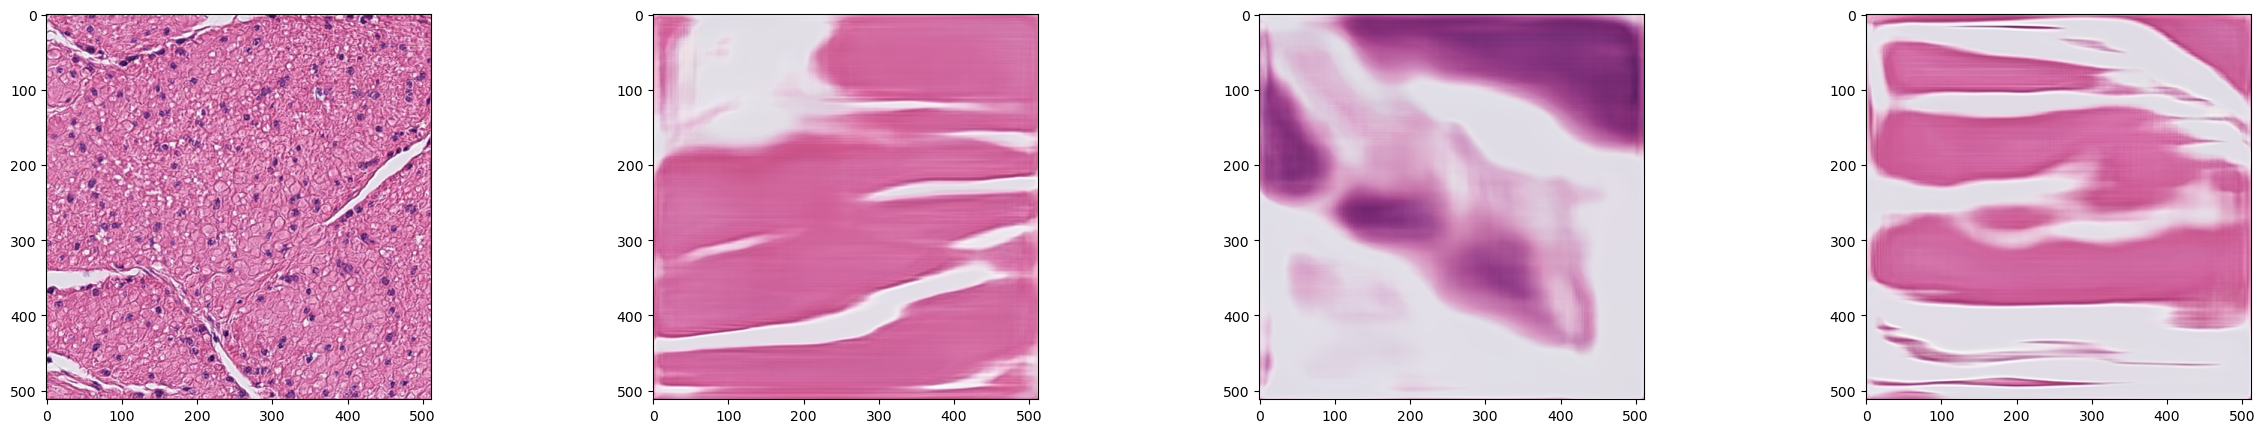

In [24]:
try:
    constZ1s
except Exception as e:
    constZ1s = npr.randn(rows*cols, zdim)
    constZ2s = npr.randn(rows*cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1)

'''
if z1s commented out, same content, different styles
if z2s commented out, different content, same styles
if noise = 0, undesirably smooth faces but just a test to make sure styles are working properly
'''
for i in range(1): 
    constZ1s = npr.randn(rows * cols, zdim)
    #constZ2s = npr.randn(rows * cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1) * 0
    pred11=display(z1=constZ1s, z2=constZ2s, noise=constNoises, verbose=False)

ValueError: Layer "generator" expects 9 input(s), but it received 8 input tensors. Inputs received: [<tf.Tensor: shape=(4, 512), dtype=float64, numpy=
array([[-2.64591961,  0.81085321, -0.91358096, ..., -1.3378588 ,
         1.39466745, -1.12684477],
       [-0.57063938,  0.65826125,  0.38623944, ...,  0.23332986,
         1.0003064 ,  0.24346567],
       [-1.02822687,  1.49471744, -2.14611396, ...,  0.46370722,
        -1.09314627,  0.32433125],
       [-1.27222567,  0.43420225, -0.80358693, ...,  0.73345961,
        -0.5590296 , -1.3446725 ]])>, <tf.Tensor: shape=(4, 512), dtype=float64, numpy=
array([[-2.64591961,  0.81085321, -0.91358096, ..., -1.3378588 ,
         1.39466745, -1.12684477],
       [-0.57063938,  0.65826125,  0.38623944, ...,  0.23332986,
         1.0003064 ,  0.24346567],
       [-1.02822687,  1.49471744, -2.14611396, ...,  0.46370722,
        -1.09314627,  0.32433125],
       [-1.27222567,  0.43420225, -0.80358693, ...,  0.73345961,
        -0.5590296 , -1.3446725 ]])>, <tf.Tensor: shape=(4, 512), dtype=float64, numpy=
array([[-2.64591961,  0.81085321, -0.91358096, ..., -1.3378588 ,
         1.39466745, -1.12684477],
       [-0.57063938,  0.65826125,  0.38623944, ...,  0.23332986,
         1.0003064 ,  0.24346567],
       [-1.02822687,  1.49471744, -2.14611396, ...,  0.46370722,
        -1.09314627,  0.32433125],
       [-1.27222567,  0.43420225, -0.80358693, ...,  0.73345961,
        -0.5590296 , -1.3446725 ]])>, <tf.Tensor: shape=(4, 512), dtype=float64, numpy=
array([[-2.64591961,  0.81085321, -0.91358096, ..., -1.3378588 ,
         1.39466745, -1.12684477],
       [ 2.33296677, -0.29974719,  0.76827622, ...,  0.78253087,
        -1.69533499, -1.32452773],
       [ 0.34340592, -0.00352951, -0.19535521, ..., -1.1891508 ,
        -0.10678603, -1.41734921],
       [-0.29343756,  0.50282955, -0.89271074, ...,  0.12577675,
        -0.70349858,  1.44586232]])>, <tf.Tensor: shape=(4, 512), dtype=float64, numpy=
array([[-2.64591961,  0.81085321, -0.91358096, ..., -1.3378588 ,
         1.39466745, -1.12684477],
       [ 2.33296677, -0.29974719,  0.76827622, ...,  0.78253087,
        -1.69533499, -1.32452773],
       [ 0.34340592, -0.00352951, -0.19535521, ..., -1.1891508 ,
        -0.10678603, -1.41734921],
       [-0.29343756,  0.50282955, -0.89271074, ...,  0.12577675,
        -0.70349858,  1.44586232]])>, <tf.Tensor: shape=(4, 512), dtype=float64, numpy=
array([[-2.64591961,  0.81085321, -0.91358096, ..., -1.3378588 ,
         1.39466745, -1.12684477],
       [ 2.33296677, -0.29974719,  0.76827622, ...,  0.78253087,
        -1.69533499, -1.32452773],
       [ 0.34340592, -0.00352951, -0.19535521, ..., -1.1891508 ,
        -0.10678603, -1.41734921],
       [-0.29343756,  0.50282955, -0.89271074, ...,  0.12577675,
        -0.70349858,  1.44586232]])>, <tf.Tensor: shape=(4, 512), dtype=float64, numpy=
array([[-2.64591961,  0.81085321, -0.91358096, ..., -1.3378588 ,
         1.39466745, -1.12684477],
       [ 2.33296677, -0.29974719,  0.76827622, ...,  0.78253087,
        -1.69533499, -1.32452773],
       [ 0.34340592, -0.00352951, -0.19535521, ..., -1.1891508 ,
        -0.10678603, -1.41734921],
       [-0.29343756,  0.50282955, -0.89271074, ...,  0.12577675,
        -0.70349858,  1.44586232]])>, <tf.Tensor: shape=(4, 512, 512, 1), dtype=float64, numpy=
array([[[[ 0.70334245],
         [-1.40891034],
         [ 0.9249341 ],
         ...,
         [-1.25124691],
         [ 0.14345203],
         [ 0.09979326]],

        [[-0.38700355],
         [ 1.54028084],
         [ 0.96736557],
         ...,
         [ 1.20589507],
         [-1.16297588],
         [-1.1176259 ]],

        [[ 0.36222306],
         [-0.01805375],
         [-0.20938666],
         ...,
         [-1.53347147],
         [-0.7359946 ],
         [-0.32332863]],

        ...,

        [[ 0.28319021],
         [ 0.05429162],
         [-0.64763309],
         ...,
         [ 0.19246269],
         [-0.11230411],
         [ 0.71582204]],

        [[ 0.99963989],
         [ 1.28759297],
         [ 1.73395977],
         ...,
         [ 0.79001281],
         [ 0.5011701 ],
         [-1.1605673 ]],

        [[-2.09394774],
         [-1.49535755],
         [ 0.47095987],
         ...,
         [-0.77095548],
         [ 0.2390795 ],
         [-1.10010094]]],


       [[[ 0.        ],
         [-0.        ],
         [-0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [ 0.        ],
         [-0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [-0.        ]],

        [[ 0.        ],
         [-0.        ],
         [ 0.        ],
         ...,
         [ 0.        ],
         [-0.        ],
         [ 0.        ]],

        ...,

        [[ 0.        ],
         [-0.        ],
         [-0.        ],
         ...,
         [ 0.        ],
         [-0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [-0.        ],
         [-0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [-0.        ],
         [-0.        ],
         ...,
         [ 0.        ],
         [-0.        ],
         [ 0.        ]]],


       [[[ 0.        ],
         [-0.        ],
         [-0.        ],
         ...,
         [ 0.        ],
         [-0.        ],
         [-0.        ]],

        [[-0.        ],
         [-0.        ],
         [-0.        ],
         ...,
         [-0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[-0.        ],
         [-0.        ],
         [-0.        ],
         ...,
         [ 0.        ],
         [-0.        ],
         [-0.        ]],

        ...,

        [[-0.        ],
         [ 0.        ],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [-0.        ]],

        [[-0.        ],
         [-0.        ],
         [ 0.        ],
         ...,
         [ 0.        ],
         [-0.        ],
         [-0.        ]],

        [[-0.        ],
         [ 0.        ],
         [-0.        ],
         ...,
         [-0.        ],
         [ 0.        ],
         [-0.        ]]],


       [[[-0.        ],
         [-0.        ],
         [-0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [-0.        ]],

        [[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         ...,
         [ 0.        ],
         [-0.        ],
         [-0.        ]],

        [[-0.        ],
         [-0.        ],
         [-0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        ...,

        [[-0.        ],
         [ 0.        ],
         [-0.        ],
         ...,
         [-0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[-0.        ],
         [ 0.        ],
         [ 0.        ],
         ...,
         [-0.        ],
         [-0.        ],
         [ 0.        ]],

        [[-0.        ],
         [ 0.        ],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [-0.        ]]]])>]

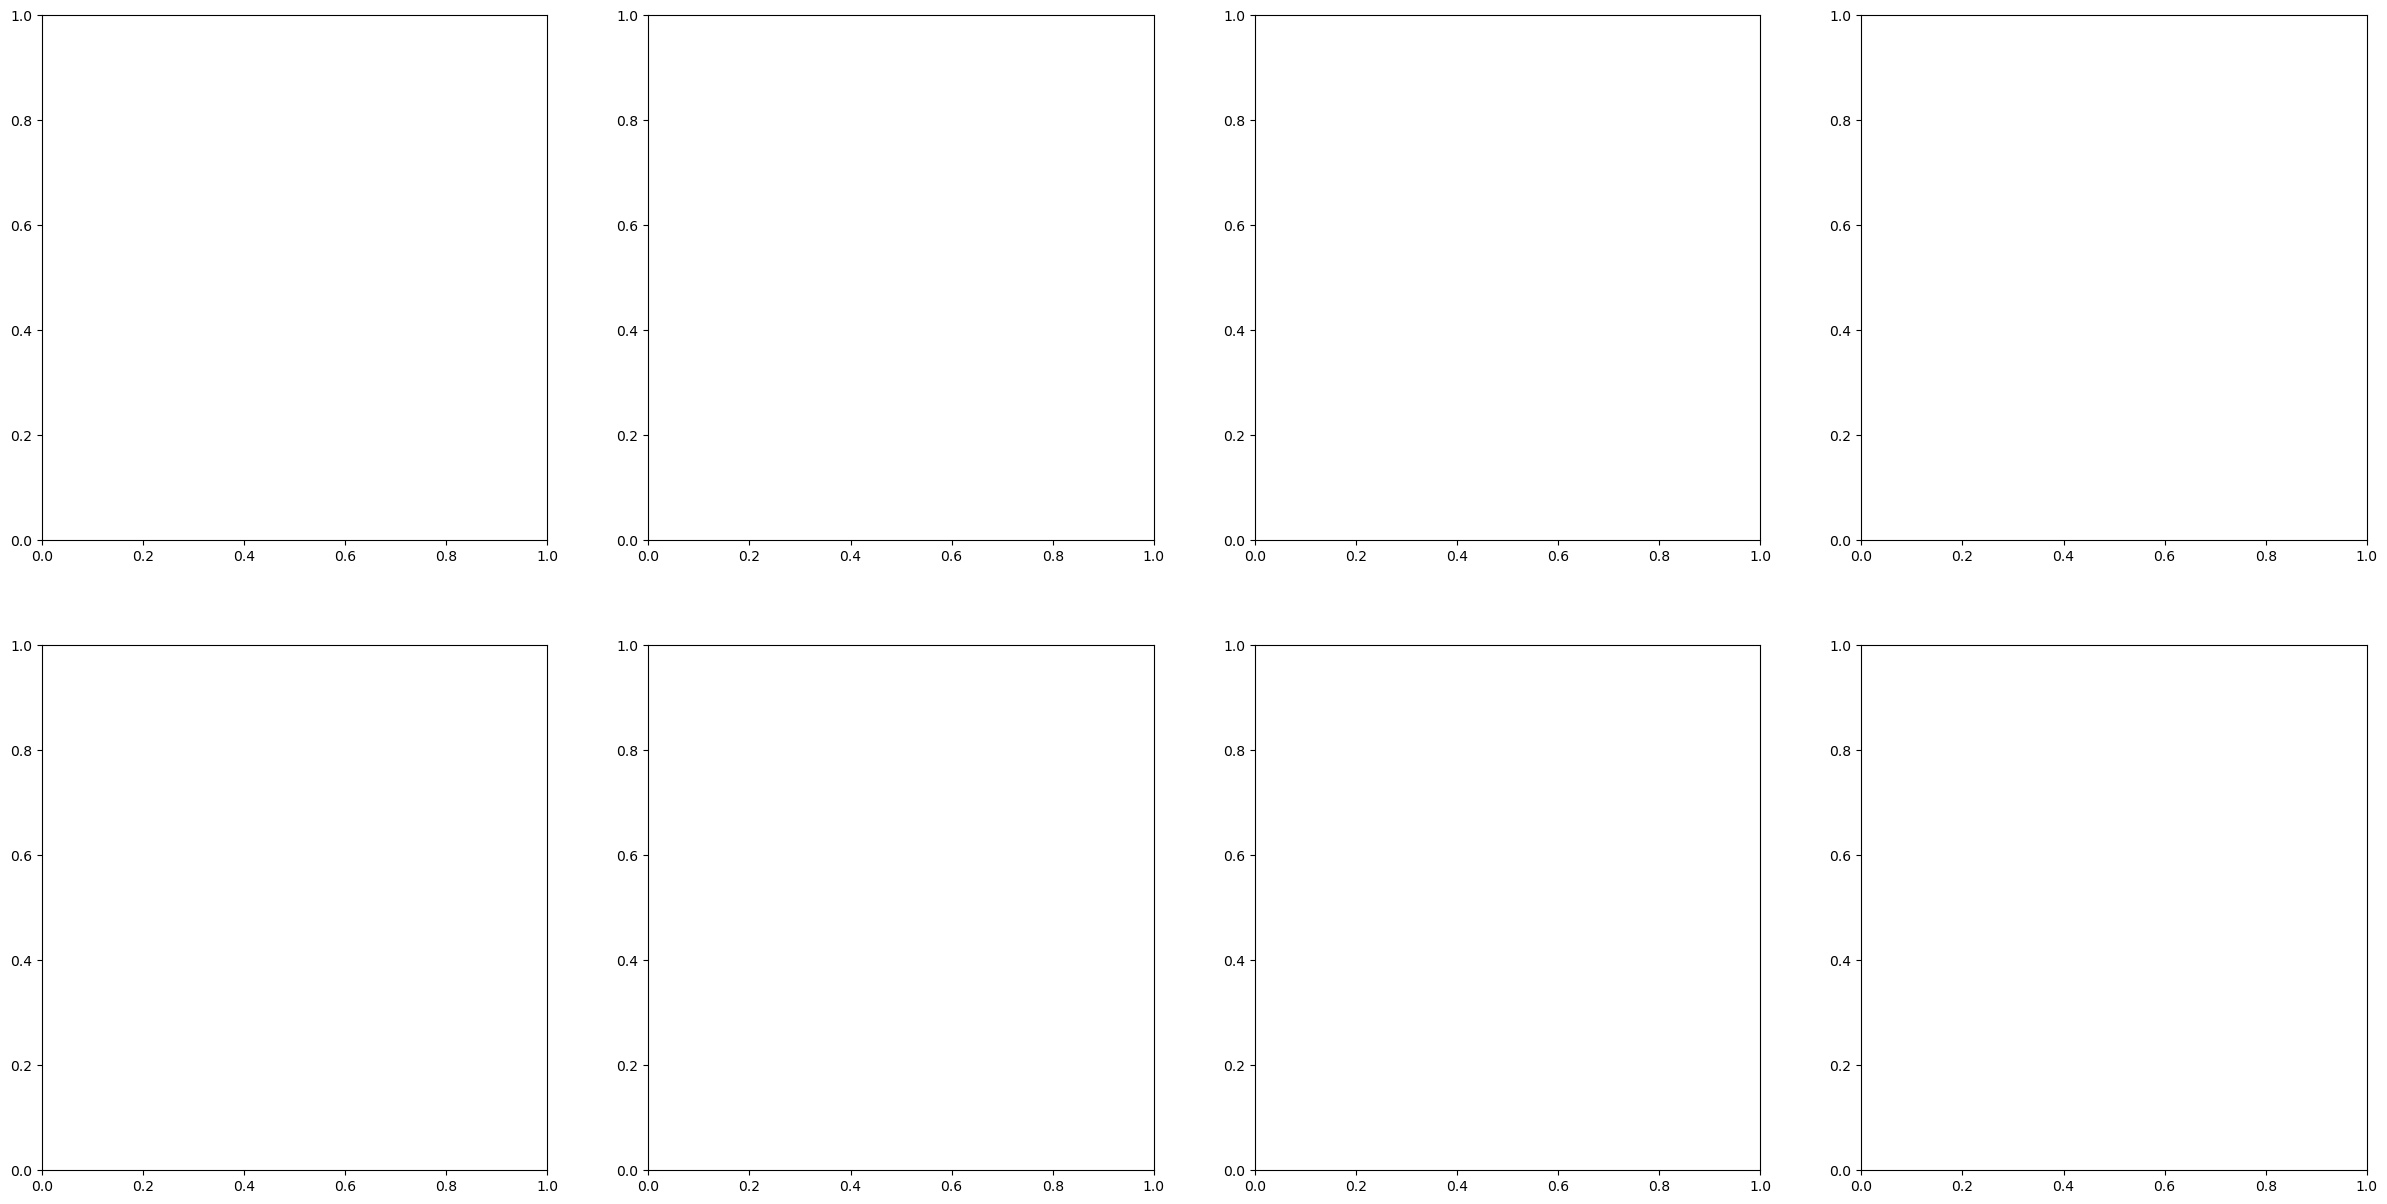

In [22]:
try:
    constZ1s
except Exception as e:
    constZ1s = npr.randn(rows*cols, zdim)
    constZ2s = npr.randn(rows*cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1)
    
fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(30, 15))

z1 = constZ1s; z2 = constZ2s; noise = constNoises

randInds = npr.randint(0, reals.shape[0], (rows*cols,))

w1 = z1; w2 = z2
ws = [w1 for i in range(3)] + [w2 for i in range(4)]
preds = generator([*ws, noise], training=False)

for i in range(cols):
    axes[0][i].imshow(preds[i] / 2 + 0.5)
    
w1 = mapper(z1, training=False)
w2 = mapper(z2, training=False)
ws = [w1 for i in range(3)] + [w2 for i in range(4)]
preds = generator([*ws, noise], training=False)

for i in range(cols):
    axes[1][i].imshow(preds[i] / 2 + 0.5)

plt.show()

See metrics over training

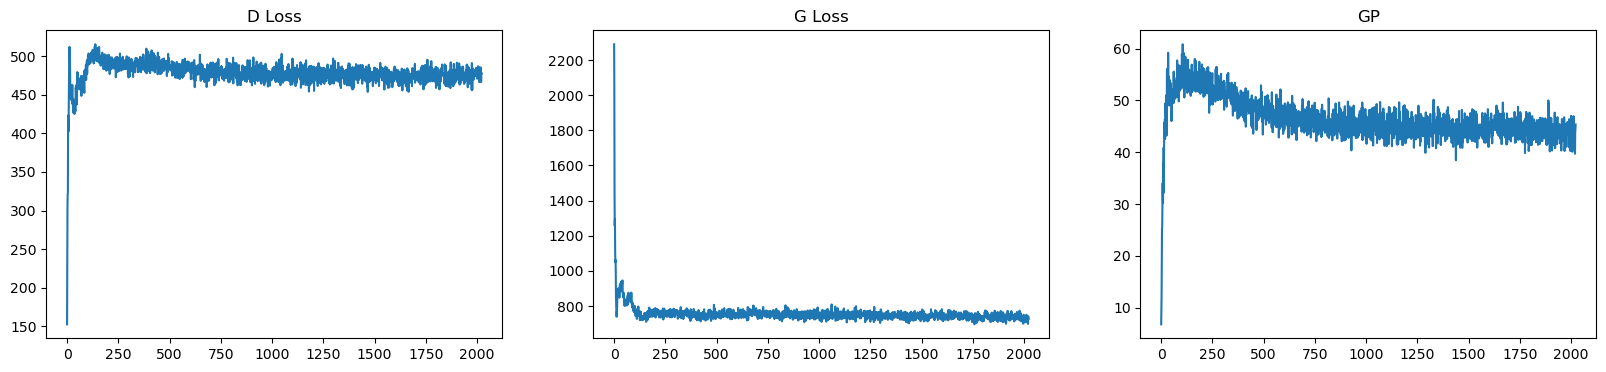

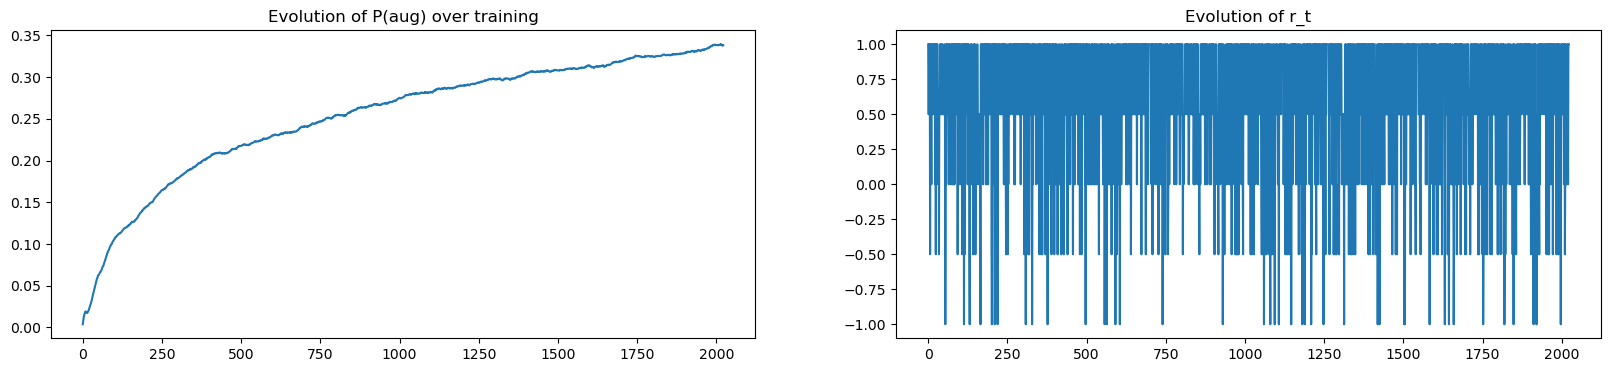

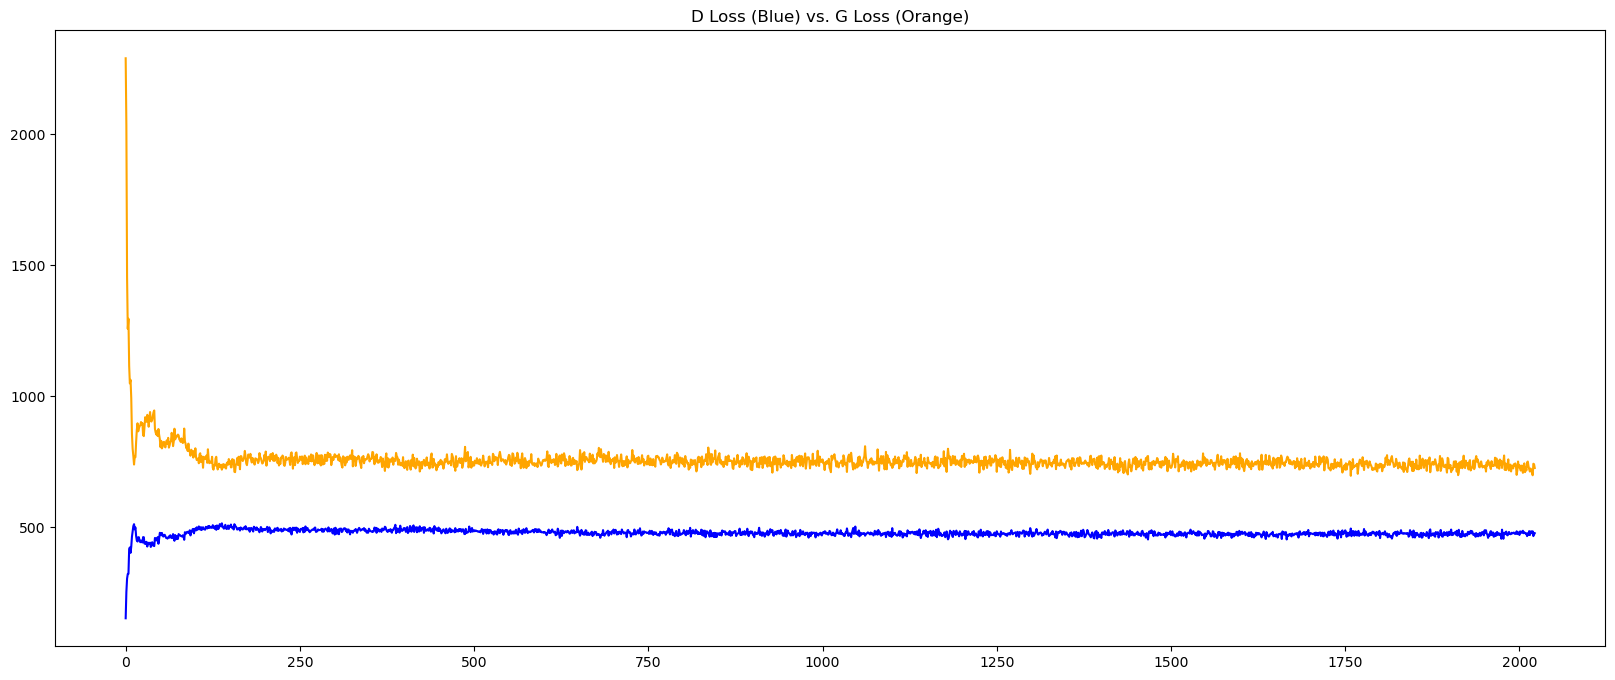

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
pltX = range(len(dcosts))
axes[0].plot(pltX, dcosts); axes[0].set_title('D Loss')
axes[1].plot(pltX, gcosts); axes[1].set_title('G Loss')
axes[2].plot(pltX, gpcosts); axes[2].set_title('GP')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
axes[0].plot(pltX, ps); axes[0].set_title('Evolution of P(aug) over training')
axes[1].plot(pltX, rts); axes[1].set_title('Evolution of r_t')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
axes.set_title('D Loss (Blue) vs. G Loss (Orange)')
axes.plot(pltX, dcosts, color='blue')
axes.plot(pltX, gcosts, color='orange')
plt.show()